## Инициализируем рабочую директорию

In [1]:
import os
from pathlib import Path

In [2]:
os.chdir(Path(os.getcwd()).parent)
os.getcwd()

'D:\\PyProjects\\EmployerTasks\\Sber_CreditRiskPDModel'

## Загружаем библиотеки

In [3]:
import pandas as pd
import numpy as np
import sklearn.metrics as skm
import sklearn.preprocessing as skpp
import sklearn.linear_model as sklm
import sklearn.model_selection as skms
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
from warnings import filterwarnings
filterwarnings('ignore')

## Фикисруем на уровне окружения случайное состояние NumPy для обеспечения воспроизводимости эксперимента, а так же настраиваем визуальное отображение Pandas

In [5]:
RANDOM_STATE = 56

np.random.seed(RANDOM_STATE)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Загружаем данные

In [6]:
credit_risk_data = pd.read_csv('data/training_set_labels.csv')

In [7]:
credit_risk_data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'no checking',18,'critical/other existing credit',radio/tv,1800,'<100','1<=X<4',4,'male single',none,2,car,24,none,own,2,skilled,1,none,yes,good
1,'<0',24,'existing paid',radio/tv,2439,'<100','<1',4,'female div/dep/mar',none,4,'real estate',35,none,own,1,skilled,1,yes,yes,bad
2,'no checking',36,'no credits/all paid',repairs,2613,'<100','1<=X<4',4,'male single',none,2,car,27,none,own,2,skilled,1,none,yes,good
3,'no checking',15,'existing paid',education,4623,'100<=X<500','1<=X<4',3,'male single',none,2,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,bad
4,'<0',21,'existing paid',furniture/equipment,3599,'<100','4<=X<7',1,'female div/dep/mar',none,4,car,26,none,rent,1,'unskilled resident',1,none,yes,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,'0<=X<200',60,'all paid',other,14782,'100<=X<500','>=7',3,'female div/dep/mar',none,4,'no known property',60,bank,'for free',2,'high qualif/self emp/mgmt',1,yes,yes,bad
796,'0<=X<200',12,'critical/other existing credit','new car',2366,'500<=X<1000','4<=X<7',3,'male div/sep',none,3,car,36,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,good
797,'no checking',9,'critical/other existing credit','new car',1224,'<100','1<=X<4',3,'male single',none,1,'real estate',30,none,own,2,skilled,1,none,yes,good
798,'<0',18,'no credits/all paid',furniture/equipment,3114,'<100','<1',1,'female div/dep/mar',none,4,'life insurance',26,none,rent,1,skilled,1,none,yes,bad


In [8]:
credit_risk_data.shape

(800, 21)

## Осуществляем верхнеурвневый обзор данных и их типов. Понимаем какие данные представляют собой непрерывные и дискретные величины. Избавляемся от object-ов, приводим типы данных к орабатываемым

In [9]:
df_dtypes = pd.DataFrame({
    'column': credit_risk_data.columns.to_list(),
    'dtype': credit_risk_data.dtypes.to_list(), 
    'uniques': credit_risk_data.nunique().to_list(),
    'type': np.where(credit_risk_data.nunique().to_numpy() > 10, 'num', 'cat')
})

df_dtypes

,column,dtype,uniques,type
0,checking_status,object,4,cat
1,duration,int64,32,num
2,credit_history,object,5,cat
3,purpose,object,10,cat
4,credit_amount,int64,751,num
5,savings_status,object,5,cat
6,employment,object,5,cat
7,installment_commitment,int64,4,cat
8,personal_status,object,4,cat
9,other_parties,object,3,cat


In [10]:
type(credit_risk_data['class'].dtype)

numpy.dtypes.ObjectDType

In [11]:
for col in credit_risk_data.columns:
    if isinstance(credit_risk_data[col].dtype, np.dtypes.ObjectDType):
        try:
            credit_risk_data[col] = credit_risk_data[col].astype(float)
        except:
            skle = skpp.LabelEncoder()
            credit_risk_data[col] = skle.fit_transform(credit_risk_data[col].to_list())

            if col != 'class':
                credit_risk_data[col] = credit_risk_data[col].astype(str)
            
            else:
                credit_risk_data[col] = credit_risk_data[col].astype(int)

In [12]:
df_dtypes = pd.DataFrame({
    'column': credit_risk_data.columns.to_list(),
    'dtype': credit_risk_data.dtypes.to_list(), 
    'uniques': credit_risk_data.nunique().to_list(),
    'type': np.where(credit_risk_data.nunique().to_numpy() > 10, 'num', 'cat')
})

df_dtypes

,column,dtype,uniques,type
0,checking_status,object,4,cat
1,duration,int64,32,num
2,credit_history,object,5,cat
3,purpose,object,10,cat
4,credit_amount,int64,751,num
5,savings_status,object,5,cat
6,employment,object,5,cat
7,installment_commitment,int64,4,cat
8,personal_status,object,4,cat
9,other_parties,object,3,cat


## Разведочный анализ

### Подсчитываем количество пропусков. Их нет, и это хорошо

In [13]:
data_anlz = credit_risk_data.copy()
data_anlz = data_anlz.isna().sum(axis=0)

data_anlz

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

### Оцениваем распределение целевой переменной

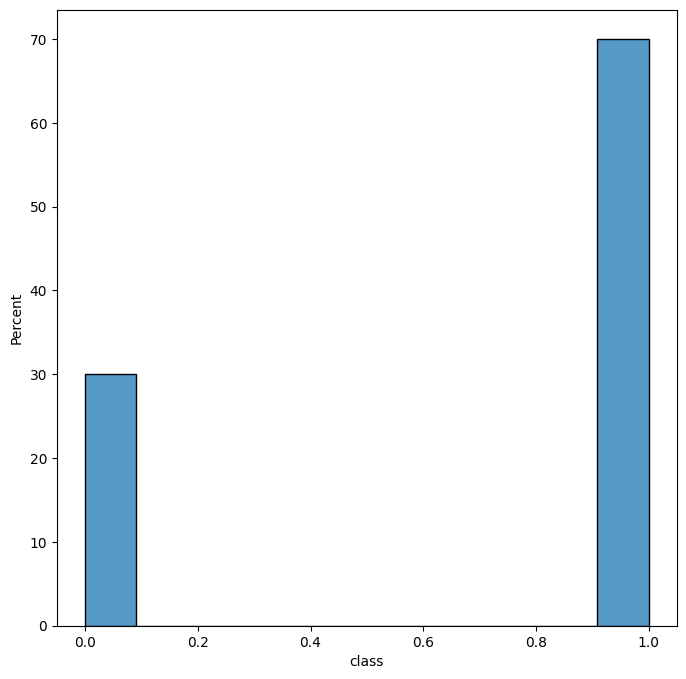

In [14]:
data_to_vis = credit_risk_data.copy()

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(8)
        
sns.histplot(data=data_to_vis['class'], stat='percent', ax=ax)
    
plt.show()

#### Всё не так плохо. Дисбаланс 70% на 30%, с учётом небольшого размера датафрейма процедура понижения размерности по строкам кажется не целесообразной. Вместо этого попробуем взвешивать наблюдения. Успех не гарантирвоан, однако гипотезу стоит проверить.

### Оценим ранжирующую способность имеющихся категориальных переменных. Будем считать переменную информативной, если распределение default rate-ов бакетов переменных отличается от равномерного. Иными словами если частотность дефолтов по бакетам отдельной переменной практически не отличается, то переменная не несет в себе полезного сигнала и может быть исключена.

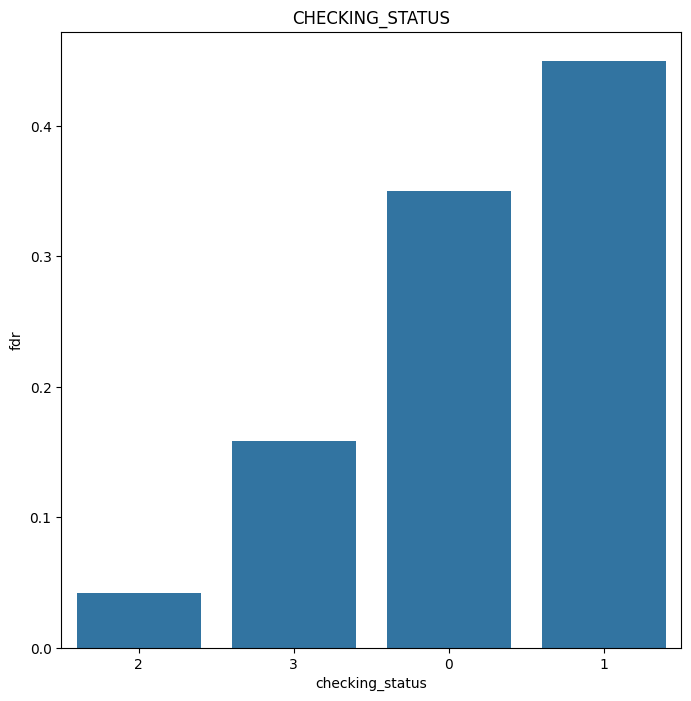

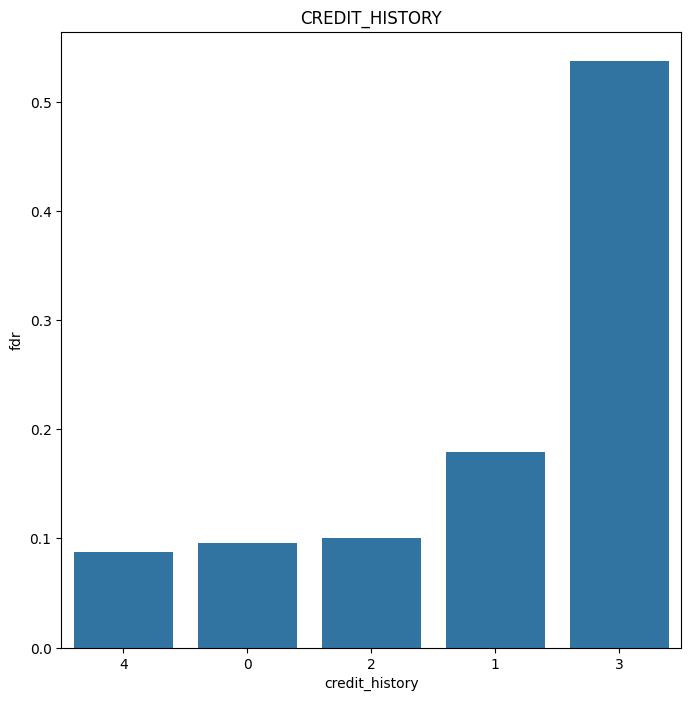

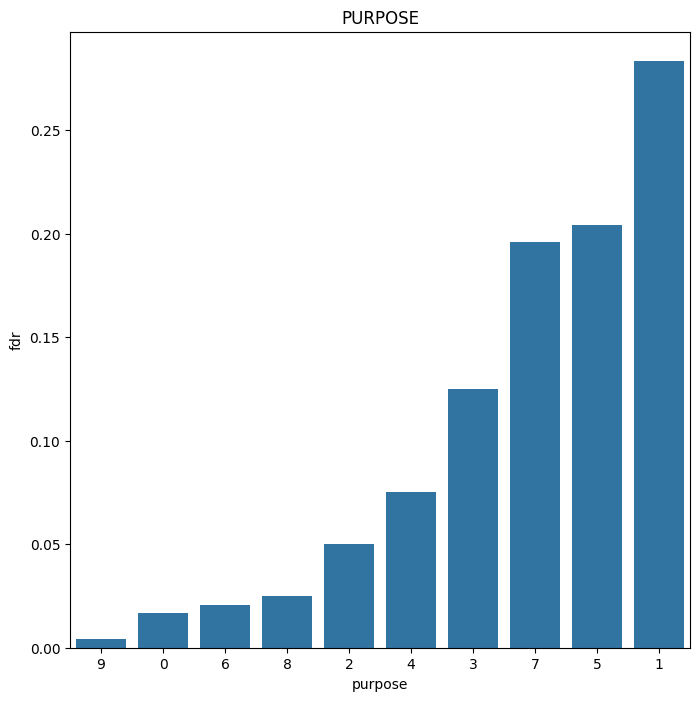

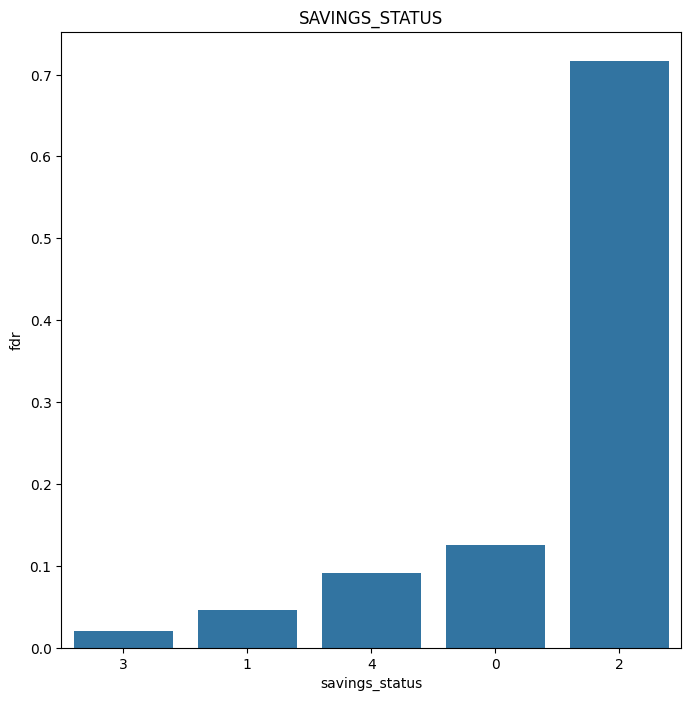

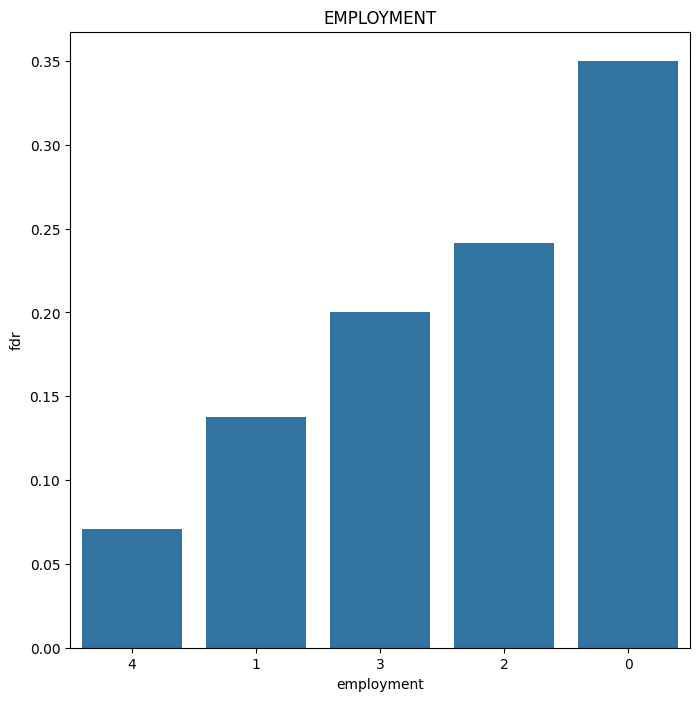

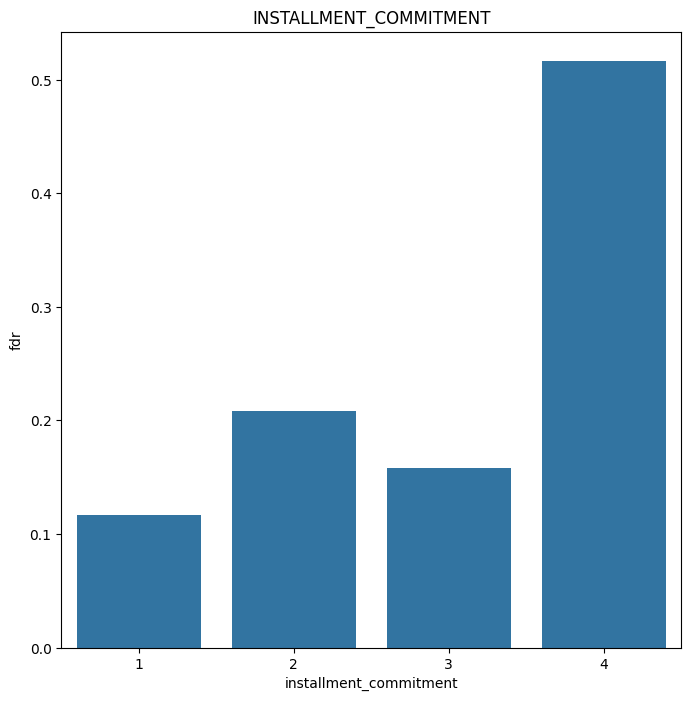

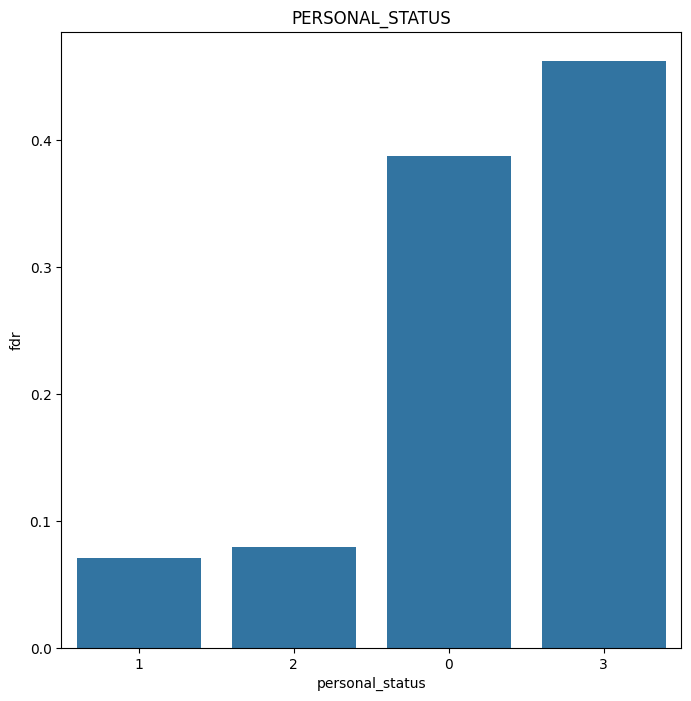

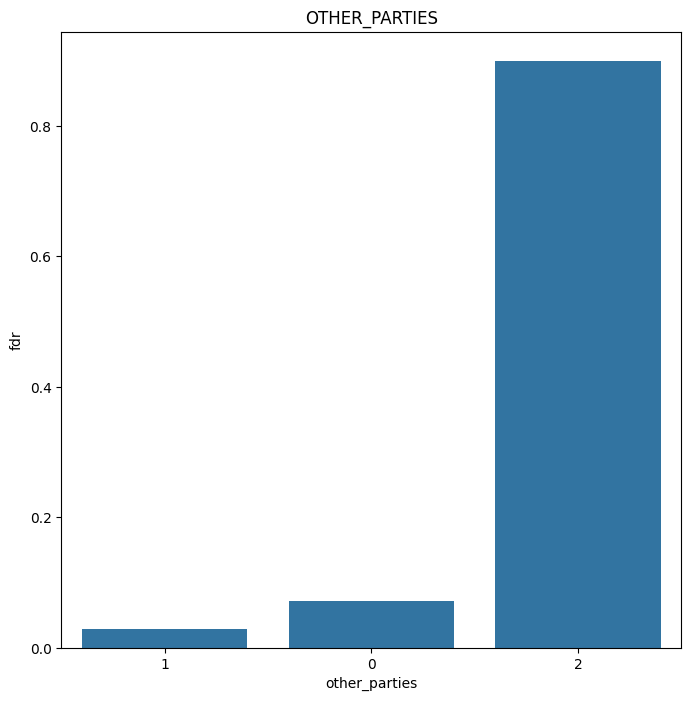

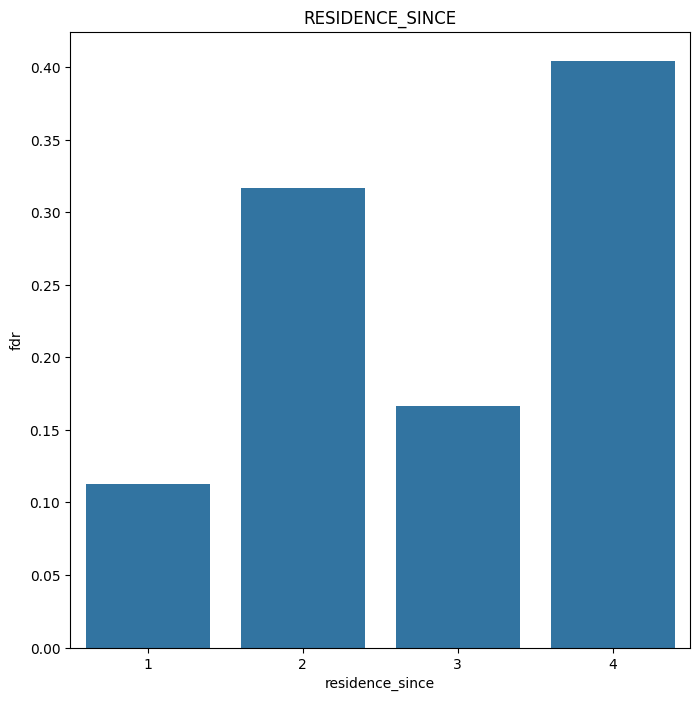

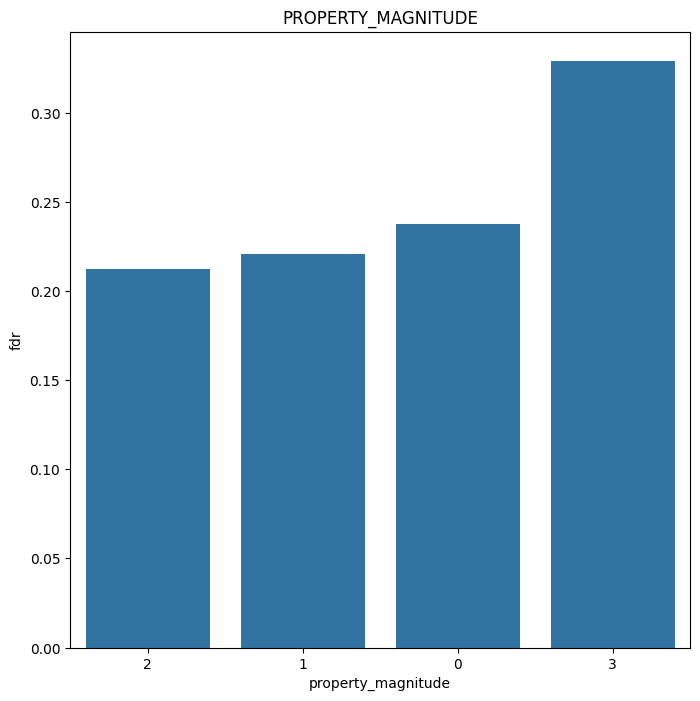

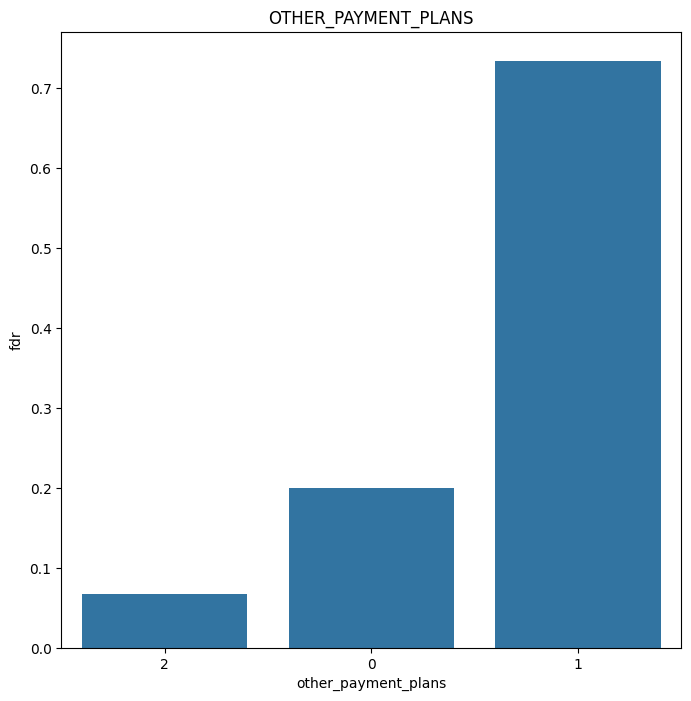

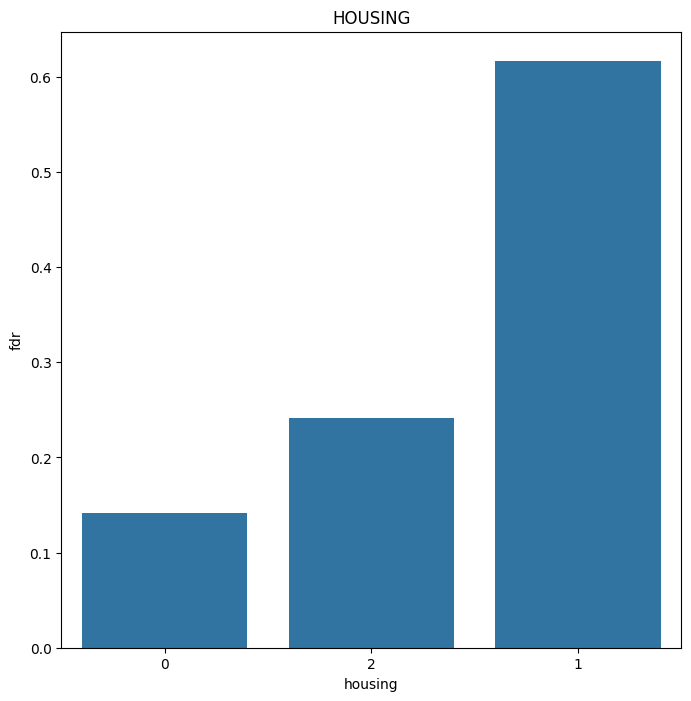

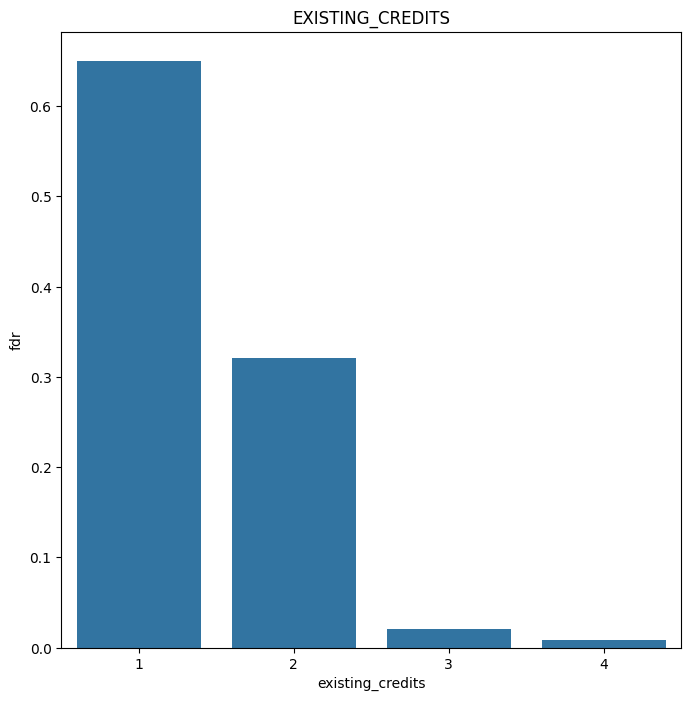

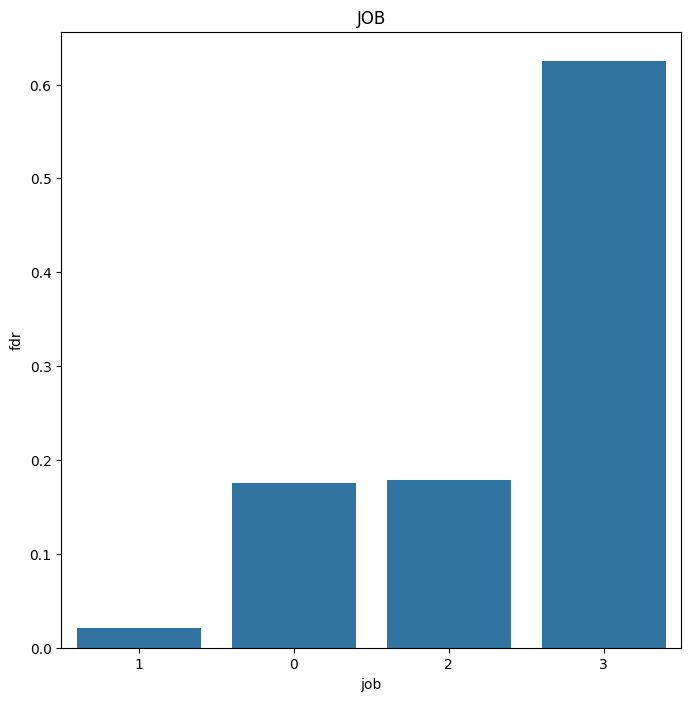

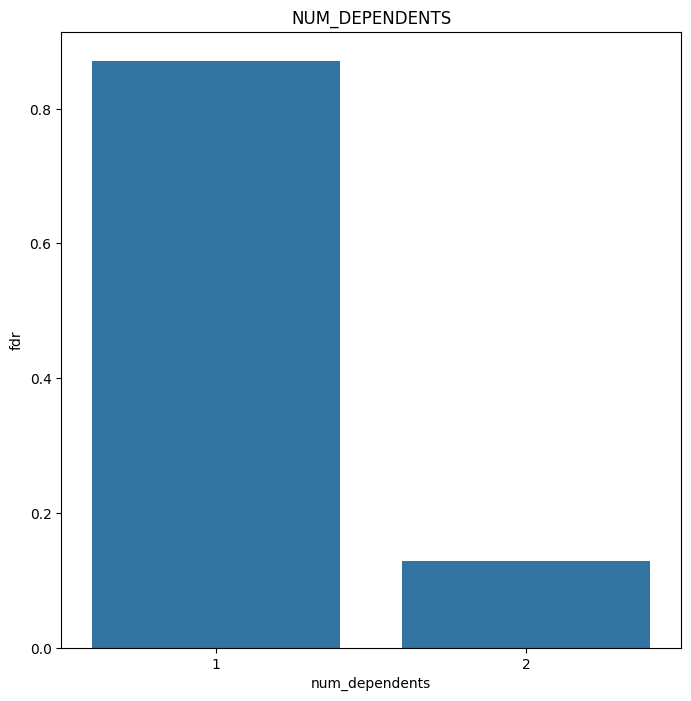

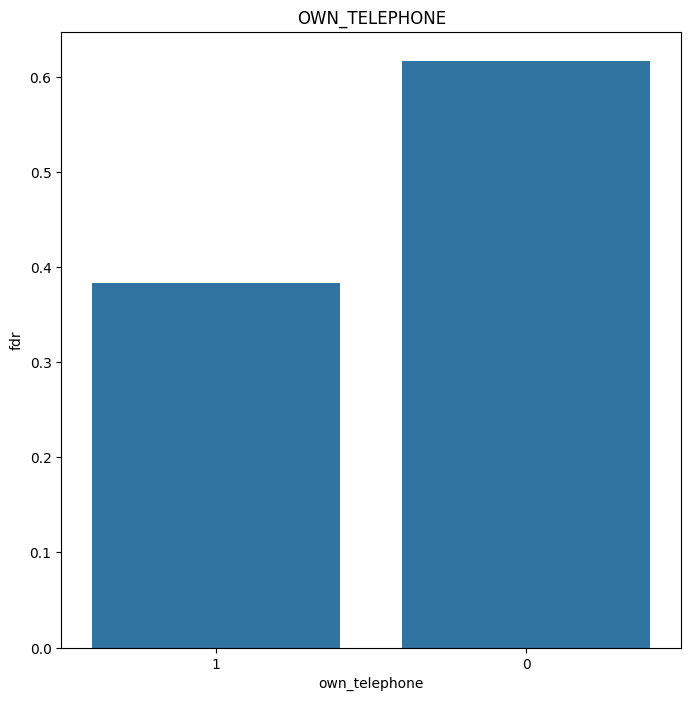

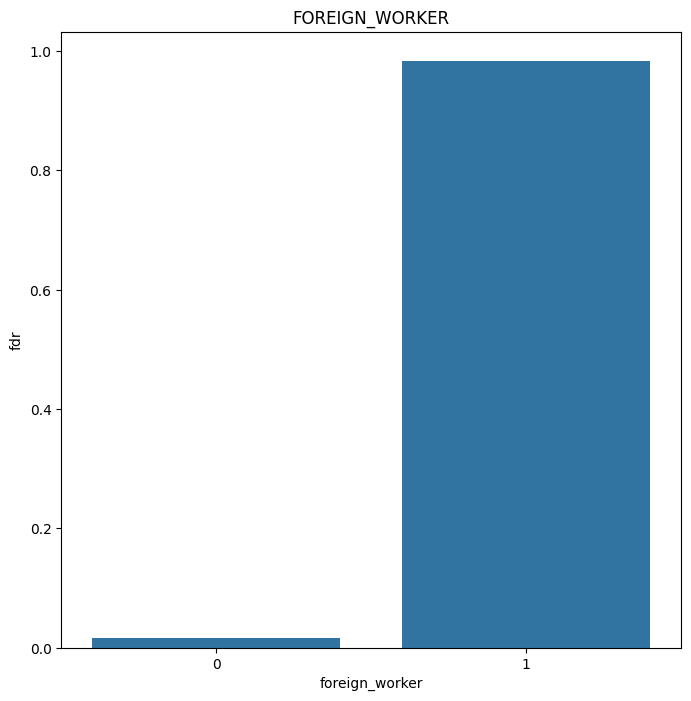

,feature,cat_count,fdr_min,fdr_max,fdr_gain,fdr_details
0,foreign_worker,2,0.016667,0.983333,68.353656,"{'0': 0.016666666666666666, '1': 0.98333333333..."
1,num_dependents,2,0.129167,0.870833,52.443753,"{2: 0.12916666666666668, 1: 0.8708333333333333}"
2,other_parties,3,0.029167,0.900000,49.118974,"{'1': 0.029166666666666667, '0': 0.07083333333..."
3,other_payment_plans,3,0.066667,0.733333,35.276684,"{'2': 0.06666666666666667, '0': 0.2, '1': 0.73..."
4,existing_credits,4,0.008333,0.650000,30.328067,"{4: 0.008333333333333333, 3: 0.020833333333333..."
5,savings_status,5,0.020833,0.716667,29.162202,"{'3': 0.020833333333333332, '1': 0.04583333333..."
6,job,4,0.020833,0.625000,26.063047,"{'1': 0.020833333333333332, '0': 0.175, '2': 0..."
7,housing,3,0.141667,0.616667,25.041632,"{'0': 0.14166666666666666, '2': 0.241666666666..."
8,personal_status,4,0.070833,0.462500,20.440745,"{'1': 0.07083333333333333, '2': 0.079166666666..."
9,credit_history,5,0.087500,0.537500,19.225453,"{'4': 0.0875, '0': 0.09583333333333334, '2': 0..."


In [15]:
data_anlz = credit_risk_data.copy()

ftr_cat_default_rates = pd.DataFrame()

for col in data_anlz.drop('class', axis=1).columns:
    if col in df_dtypes[df_dtypes['type'] == 'cat']['column'].to_list(): 
        sample = data_anlz[[col, 'class']]
        sample.loc[:, 'fdr'] = sample.groupby(col)['class'] \
            .transform(lambda x: x[x == 0].shape[0] / (data_anlz.shape[0] - data_anlz['class'].sum()))

        sample = sample[[col, 'fdr']].drop_duplicates().sort_values('fdr').reset_index(drop=True)

        fig, ax = plt.subplots()
        fig.set_figwidth(8)
        fig.set_figheight(8)
                
        sns.barplot(data=sample, x=col, y='fdr', ax=ax)
        ax.set_title(f'{col}'.upper())
            
        plt.show()        

        sample_def_rates = pd.DataFrame({
            'feature': [col],
            'cat_count': [sample.shape[0]],
            'fdr_min': [sample['fdr'].min()],
            'fdr_max': [sample['fdr'].max()],
            'fdr_gain': [((sample['fdr'] - (1 / sample.shape[0])) * 100).std()],
            'fdr_details': [{k: v for (k, v) in zip(sample[col].to_list(), sample['fdr'].to_list())}]
        })

        ftr_cat_default_rates = pd.concat((ftr_cat_default_rates, sample_def_rates)) \
            .sort_values(by='fdr_gain', ascending=False) \
            .reset_index(drop=True)

ftr_cat_default_rates

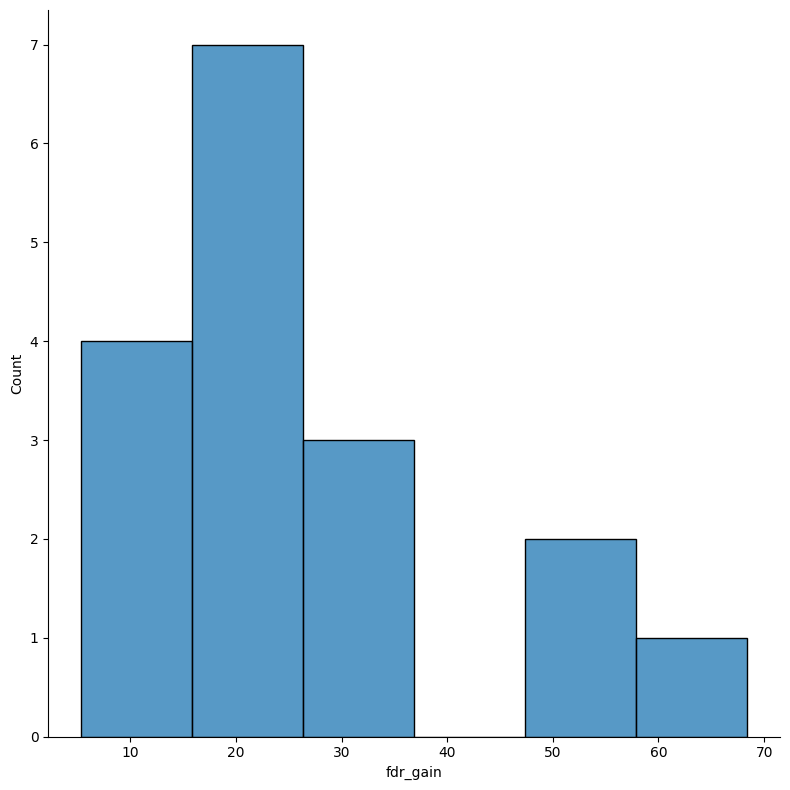

In [16]:
sns.displot(ftr_cat_default_rates['fdr_gain'], height=8)

In [17]:
ftr_cat_default_rates['fdr_gain'].quantile(np.arange(0, 1, 0.025))

0.000     5.379144
0.025     7.124303
0.050     8.869463
0.075     9.910859
0.100    10.248490
0.125    10.586122
0.150    11.721341
0.175    12.856560
0.200    14.039167
0.225    15.269163
0.250    16.499158
0.275    17.166875
0.300    17.834592
0.325    18.219061
0.350    18.320283
0.375    18.421505
0.400    18.743084
0.425    19.064664
0.450    19.468512
0.475    19.954629
0.500    20.440745
0.525    22.281100
0.550    24.121455
0.575    25.245915
0.600    25.654481
0.625    26.063047
0.650    27.302709
0.675    28.542371
0.700    29.395375
0.725    29.861721
0.750    30.328067
0.775    32.307514
0.800    34.286961
0.825    38.045142
0.850    43.582058
0.875    49.118974
0.900    50.448886
0.925    51.778797
0.950    55.625733
0.975    61.989694
Name: fdr_gain, dtype: float64

Абсолютное большинство признаков за исключением "property_magnitude" имеют существенную вариацию частоты встречаемости дефолта. Таким образом можем выкинуть "property_magnitude", остальные признаки на текущем этапе можно не трогать. В целом дискретных признаков не так много на фоне количества наблюдений, количество степеней свободы более чем достаточно ( > 100). Отбрасывание большого количество признаков с учётом обозначенной специфки не целесобразно

In [18]:
cat_features = ftr_cat_default_rates[ftr_cat_default_rates['feature'] != 'property_magnitude']['feature'].to_list()

cat_features

['foreign_worker',
 'num_dependents',
 'other_parties',
 'other_payment_plans',
 'existing_credits',
 'savings_status',
 'job',
 'housing',
 'personal_status',
 'credit_history',
 'checking_status',
 'installment_commitment',
 'own_telephone',
 'residence_since',
 'employment',
 'purpose']

### Реализуем аналогичную процедуру в отнощении вещественных признаков.

Отрисуем рапспределение вещественных признаков

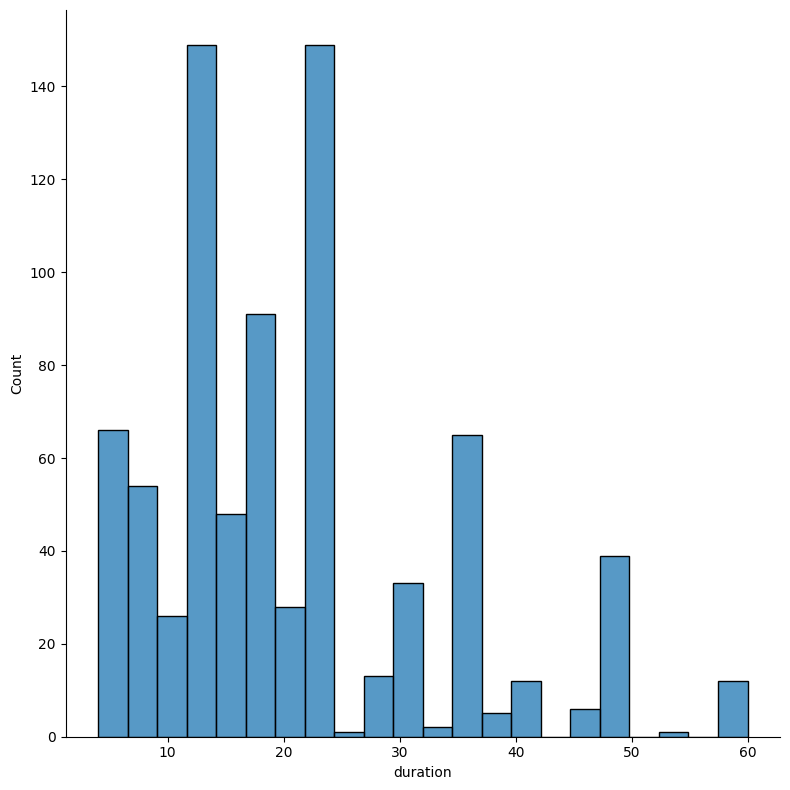

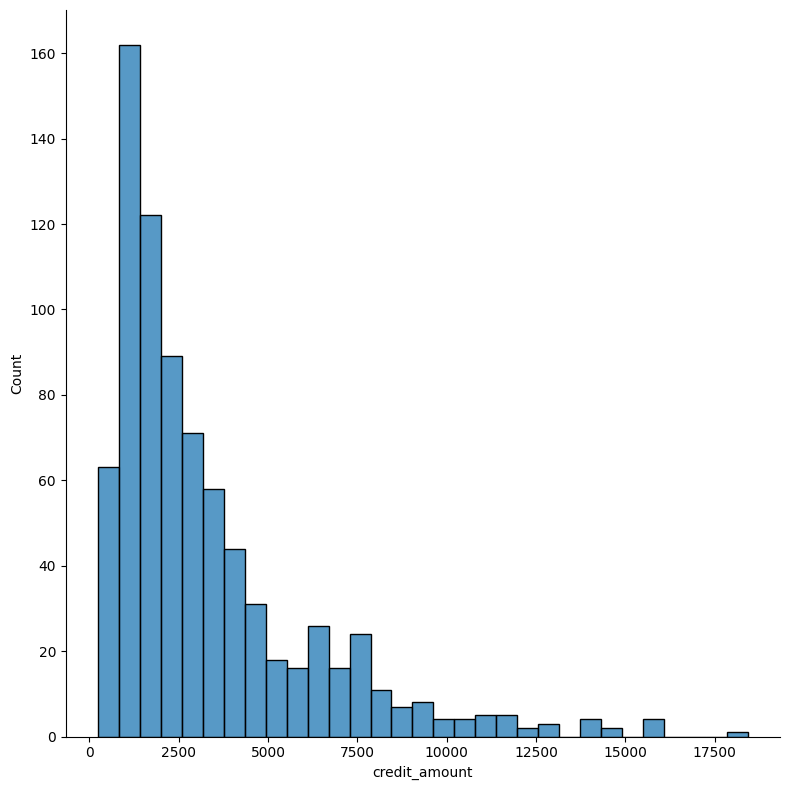

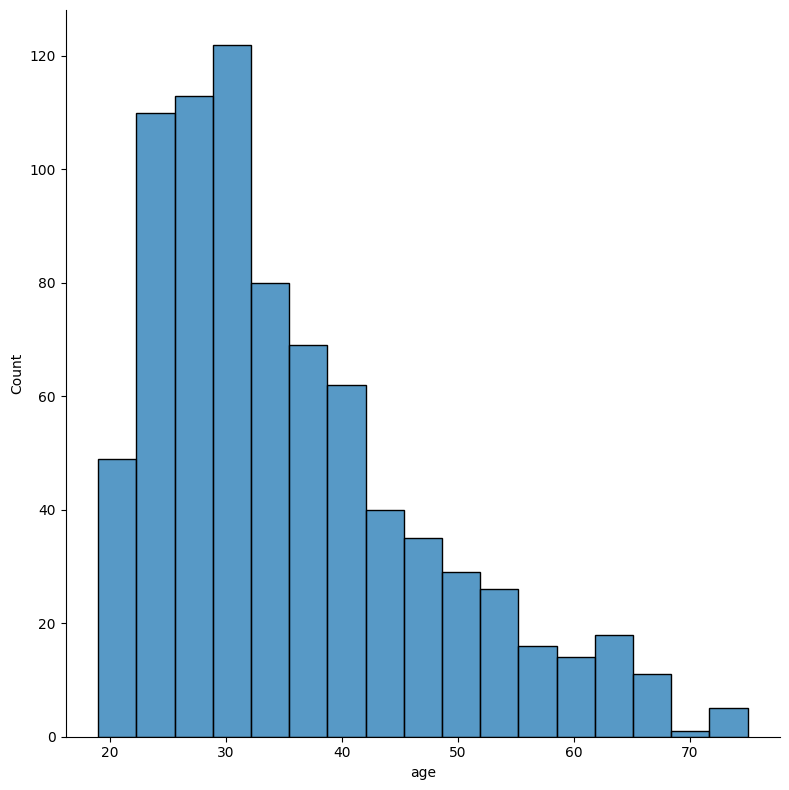

In [19]:
for col in data_anlz.drop('class', axis=1).columns:
    if col in df_dtypes[df_dtypes['type'] == 'num']['column'].to_list(): 
        sample = data_anlz[[col, 'class']]
        
        sns.displot(sample[col], height=8)        

Распределения очевидно лог-нормальны. Для дискретизации будем использовать "quantile binning", что позволит сконцентрировтаь примерно равное количество наблюдений в каждом бакете

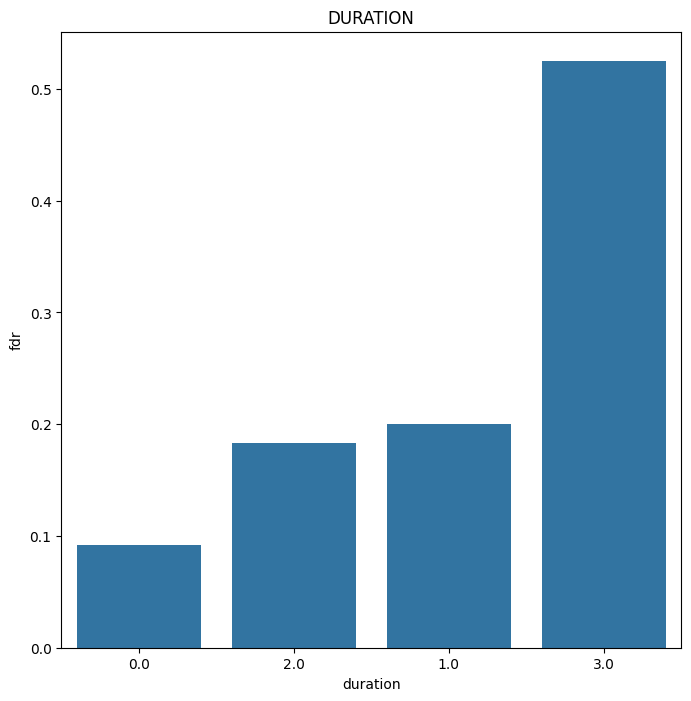

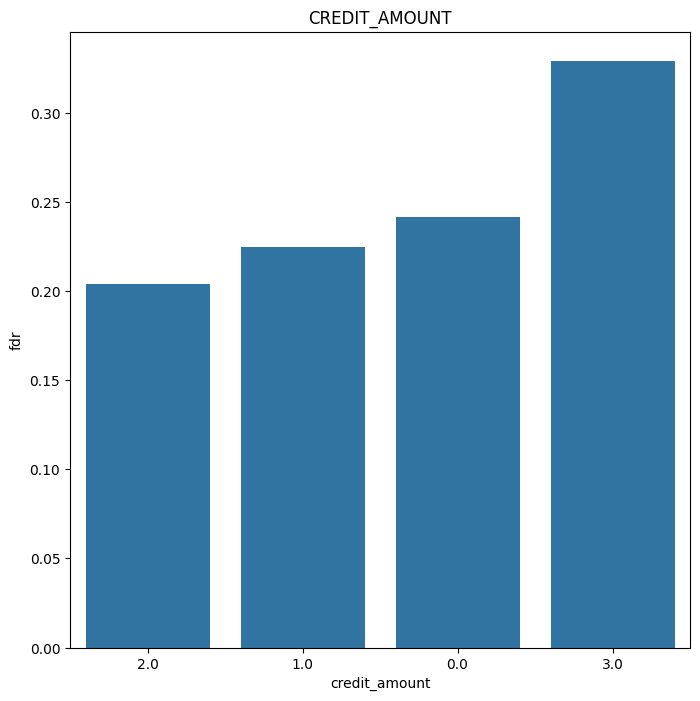

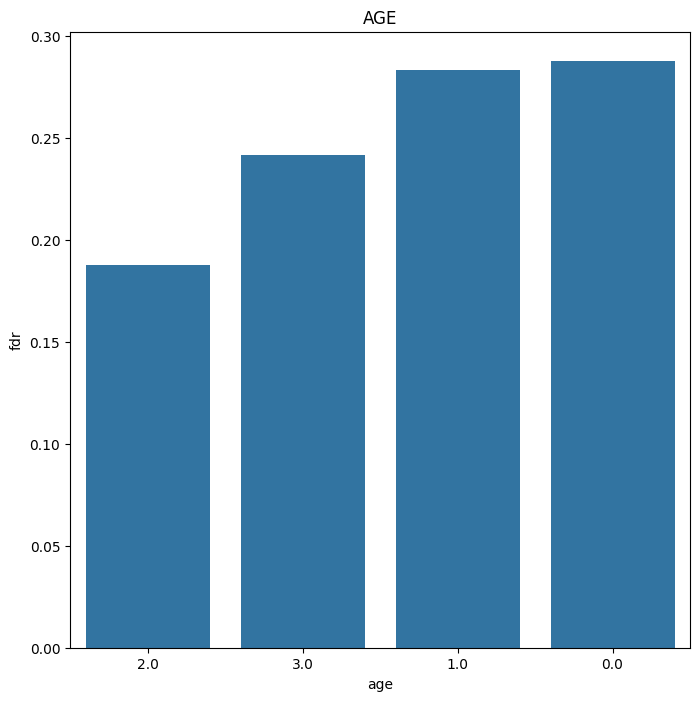

,feature,cat_count,fdr_min,fdr_max,fdr_gain,fdr_details
0,duration,4,0.091667,0.525000,18.941919,"{'0.0': 0.09166666666666666, '2.0': 0.18333333..."
1,credit_amount,4,0.204167,0.329167,5.496211,"{'2.0': 0.20416666666666666, '1.0': 0.225, '0...."
2,age,4,0.187500,0.287500,4.652260,"{'2.0': 0.1875, '3.0': 0.24166666666666667, '1..."


In [20]:
data_anlz = credit_risk_data.copy()

ftr_cat_default_rates = pd.DataFrame()

for col in data_anlz.drop('class', axis=1).columns:
    if col in df_dtypes[df_dtypes['type'] == 'num']['column'].to_list(): 
        sample = data_anlz[[col, 'class']]

        discretizer = skpp.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
        
        sample[col] = discretizer.fit_transform(sample[col].to_numpy()[np.newaxis].T)
        sample[col] = sample[col].astype(str)
        
        sample.loc[:, 'fdr'] = sample.groupby(col)['class'] \
            .transform(lambda x: x[x == 0].shape[0] / (data_anlz.shape[0] - data_anlz['class'].sum()))

        sample = sample[[col, 'fdr']].drop_duplicates().sort_values('fdr').reset_index(drop=True)

        fig, ax = plt.subplots()
        fig.set_figwidth(8)
        fig.set_figheight(8)
                
        sns.barplot(data=sample, x=col, y='fdr', ax=ax)
        ax.set_title(f'{col}'.upper())
            
        plt.show()        

        sample_def_rates = pd.DataFrame({
            'feature': [col],
            'cat_count': [sample.shape[0]],
            'fdr_min': [sample['fdr'].min()],
            'fdr_max': [sample['fdr'].max()],
            'fdr_gain': [((sample['fdr'] - (1 / sample.shape[0])) * 100).std()],
            'fdr_details': [{k: v for (k, v) in zip(sample[col].to_list(), sample['fdr'].to_list())}]
        })

        ftr_cat_default_rates = pd.concat((ftr_cat_default_rates, sample_def_rates)) \
            .sort_values(by='fdr_gain', ascending=False) \
            .reset_index(drop=True)

ftr_cat_default_rates

Кажется, что все признаки кроме "duration" слабо ранжируют дефолты. С учётом того, что мы имеем всего 3 вещественных признака, а количество степеней свободы значительно, весомой мотивации оставлять единственный вещественный признак нет

In [21]:
num_features = ftr_cat_default_rates['feature'].to_list()

num_features

['duration', 'credit_amount', 'age']

## Моделирование

### Подготовим тренировочную и тестовую выборки. 

In [22]:
from copy import deepcopy

In [23]:
features = num_features + cat_features
target = 'class' 

X_train, X_test, y_train, y_test = skms.train_test_split(
    credit_risk_data[features],
    credit_risk_data[target],
    test_size=0.3,
    shuffle=True,
    random_state=RANDOM_STATE,
    stratify=credit_risk_data[target].to_numpy()
)

X_test_orig = deepcopy(X_test)
y_test_orig = deepcopy(y_test)

#### Подготовим веса наблюдений для построения алтернативной модели. Проверим наличие прироста качества при использовании весовых коэффициентов

Веса будем инициализировать как произведение 2-х параметров: 
 - Отношение частотности доминирующего класса к минорному (для выравнивания дисбаланса пр расчёте потерь, будем сильнее штрафовать за предсказание не 0-й метки)
 - Принадлежность наблюдения к когорте кредитных лимитов, занимающей ту или иную долю в портфеле (будем сильнее штрафовать наблюдения составляющие более существенную часть объёма кредитных лимитов, другими словами будем учить модель лучше предсказывать сегменты портфеля с большей капитализацией) 

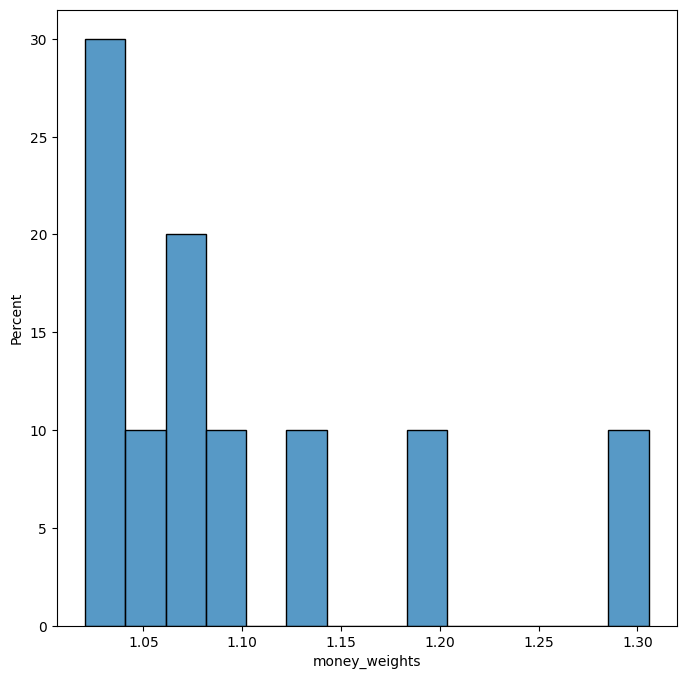

In [24]:
discretizer = skpp.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
      
X_train['money_weights'] = discretizer.fit_transform(X_train['credit_amount'].to_numpy()[np.newaxis].T)
X_train['money_weights'] = X_train['money_weights'].astype(str)
X_train['money_weights'] = (X_train.groupby('money_weights')['credit_amount'].transform('sum') / X_train['credit_amount'].sum()) + 1

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(8)
        
sns.histplot(data=X_train['money_weights'], stat='percent', ax=ax)

plt.show()

In [25]:
X_train['weights'] = np.where(y_train == 0, y_train[y_train == 1].shape[0] / y_train[y_train == 0].shape[0], 1) * X_train['money_weights']

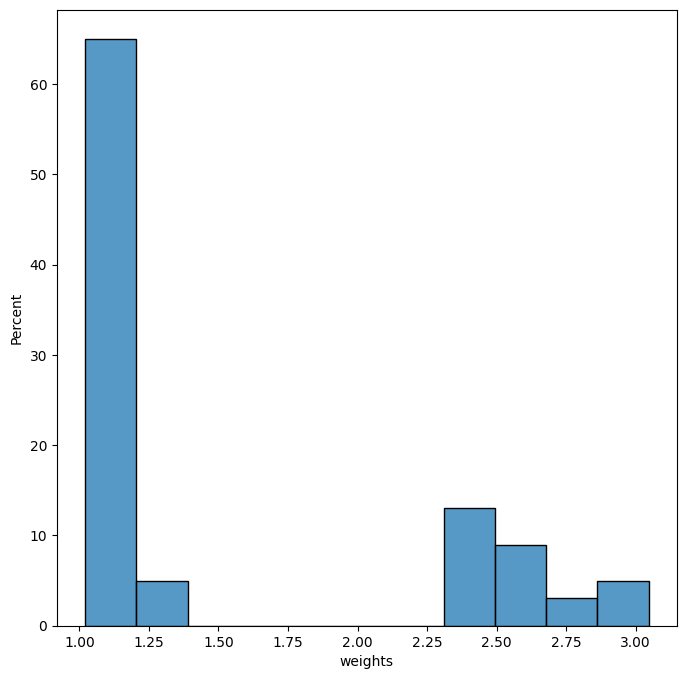

In [26]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(8)
        
sns.histplot(data=X_train['weights'], stat='percent', ax=ax)

plt.show()

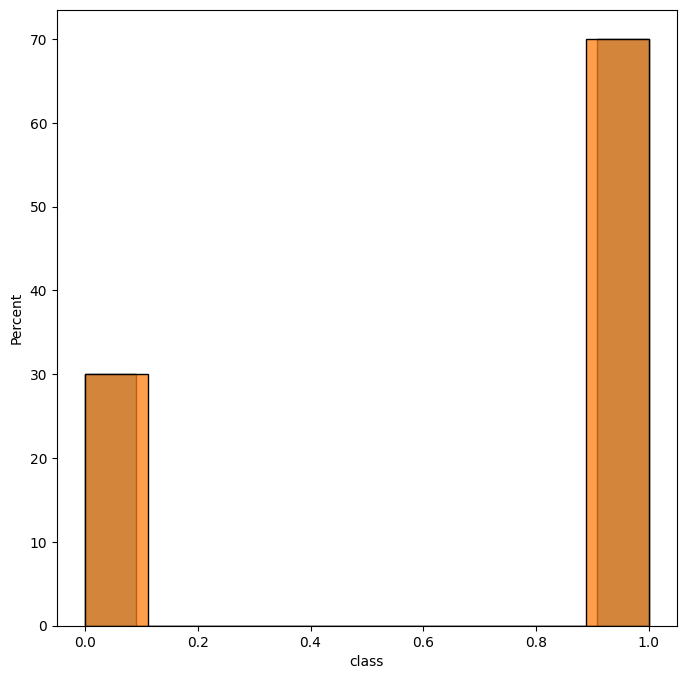

In [27]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(8)
        
sns.histplot(data=y_train, stat='percent', ax=ax)
sns.histplot(data=y_test, stat='percent', ax=ax)

plt.show()

### Сделаем таргет энкодинг категориальных и вещественных признаков 

#### Закодируем категориальные признаки

In [28]:
tarenc = skpp.TargetEncoder(
    target_type='binary',
    shuffle=True,
    random_state=RANDOM_STATE
)

In [29]:
X_train.loc[:, cat_features] = tarenc.fit_transform(X_train.loc[:, cat_features].to_numpy(), y_train)

In [30]:
X_train.loc[:, cat_features]

,foreign_worker,num_dependents,other_parties,other_payment_plans,existing_credits,savings_status,job,housing,personal_status,credit_history,checking_status,installment_commitment,own_telephone,residence_since,employment,purpose
64,0.692859,0.693736,0.693845,0.731223,0.706694,0.643095,0.690179,0.733037,0.737296,0.715531,0.874461,0.676595,0.692914,0.669249,0.59373,0.6068
311,0.928823,0.741858,0.693845,0.731223,0.706694,0.645042,0.743431,0.608919,0.729729,0.715531,0.874461,0.662865,0.692914,0.669249,0.697209,0.6068
228,0.696067,0.691126,0.709339,0.73017,0.705865,0.877217,0.702123,0.740269,0.755462,0.693367,0.600953,0.681258,0.680688,0.680425,0.708283,0.601142
333,0.860736,0.756807,0.79629,0.727199,0.721753,0.673581,0.709639,0.560542,0.744854,0.725463,0.909689,0.784489,0.695828,0.687155,0.707084,0.60315
224,0.692859,0.693736,0.693845,0.731223,0.690857,0.643095,0.690179,0.629751,0.729729,0.810628,0.874461,0.662865,0.692914,0.729255,0.756318,0.521404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.693747,0.696341,0.706155,0.739623,0.720511,0.870125,0.690749,0.749075,0.745863,0.718097,0.875934,0.670257,0.730171,0.714072,0.767338,0.62461
594,0.692859,0.741858,0.693845,0.731223,0.706694,0.643095,0.690179,0.733037,0.729729,0.715531,0.874461,0.753569,0.692914,0.669249,0.697209,0.80737
580,0.696769,0.686210,0.704425,0.738792,0.714741,0.639656,0.706502,0.734472,0.739693,0.706397,0.527454,0.781224,0.705856,0.698165,0.743098,0.639867
317,0.692859,0.693736,0.693845,0.731223,0.690857,0.916966,0.690179,0.733037,0.729729,0.810628,0.620581,0.662865,0.712644,0.669249,0.755512,0.68204


In [31]:
with open('models/config/LogReg/CatTargetEncoder.pkl', 'wb') as tarenc_path:
    pickle.dump(tarenc, tarenc_path, protocol=4)

#### Закодируем вещественные признаки

Сначала мы произведем упорядоченную дискретизацию вещественных признаков, таким образом, что бы в каждом бакете трансформированного признака находилось примерно одинаковое число наблюдений. Затем как и в случае с категориальными признаками - произведём таргет энкодинг для каждого бакета.

In [32]:
discretizer = skpp.KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

tarenc = skpp.TargetEncoder(
    target_type='binary',
    shuffle=True,
    random_state=RANDOM_STATE
)

In [33]:
X_train.loc[:, num_features] = discretizer.fit_transform(X_train.loc[:, num_features])

In [34]:
X_train.loc[:, num_features]

,duration,credit_amount,age
64,5,1,2
311,1,2,5
228,2,0,0
333,1,5,1
224,5,6,6
...,...,...,...
702,2,3,6
594,1,4,4
580,6,7,1
317,4,4,4


In [35]:
with open('models/config/LogReg/NumFeaturesDiscretizer.pkl', 'wb') as discretizer_path:
    pickle.dump(discretizer, discretizer_path, protocol=4)

In [36]:
X_train.loc[:, num_features] = tarenc.fit_transform(X_train.loc[:, num_features].to_numpy(), y_train)

In [37]:
X_train.loc[:, num_features]

,duration,credit_amount,age
64,0.652256,0.711685,0.672618
311,0.839787,0.805652,0.802029
228,0.724717,0.672618,0.594342
333,0.813630,0.737125,0.566996
224,0.652256,0.579638,0.774805
...,...,...,...
702,0.749435,0.744700,0.723728
594,0.839787,0.730240,0.656521
580,0.549745,0.537820,0.598667
317,0.618220,0.730240,0.656521


In [38]:
with open('models/config/LogReg/NumTargetEncoder.pkl', 'wb') as tarenc_path:
    pickle.dump(tarenc, tarenc_path, protocol=4)

#### Нормализация

Теперь, когда содеражние всех признаков приведено к единой логике и масштабу - можем произвести нормализацию. Z-нормализации мы использовать не можем так как область допустимых значений каждого признака расположена между 0 и 1. Вместо этого мы можем использовать MinMax нормализацию и затем вычесть "0.5" для центрирования.  

In [39]:
scaler = skpp.MinMaxScaler()

In [40]:
X_train.loc[:, features] = scaler.fit_transform(X_train.loc[:, features]) - 0.5

In [41]:
X_train.loc[:, features]

,duration,credit_amount,age,foreign_worker,num_dependents,other_parties,other_payment_plans,existing_credits,savings_status,job,housing,personal_status,credit_history,checking_status,installment_commitment,own_telephone,residence_since,employment,purpose
64,-0.143219,0.116957,-0.028698,-0.499978,-0.417021,-0.052949,0.466927,0.206694,-0.458614,-0.000411,0.423346,0.237126,0.33545,0.417567,-0.201093,-0.212188,-0.271648,-0.295175,-0.188976
311,0.347860,0.396265,0.423163,0.5,0.113556,-0.052949,0.466927,0.206694,-0.451801,0.473127,-0.169863,0.214732,0.33545,0.417567,-0.290313,-0.212188,-0.271648,0.165919,-0.188976
228,0.046531,0.000833,-0.302014,-0.486385,-0.445806,-0.010529,0.462781,0.205865,0.36087,0.1058,0.457911,0.290891,0.298994,-0.222434,-0.170794,-0.445897,-0.175517,0.215261,-0.19889
333,0.279363,0.192575,-0.397500,0.211457,0.278382,0.227522,0.451081,0.221753,-0.351906,0.172632,-0.401074,0.259495,0.351786,0.5,0.500000,-0.156484,-0.117627,0.209918,-0.195371
224,-0.143219,-0.275544,0.328106,-0.499978,-0.417021,-0.052949,0.466927,0.190857,-0.458614,-0.000411,-0.070299,0.214732,0.491867,0.417567,-0.290313,-0.212188,0.244516,0.429303,-0.338608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.111259,0.215090,0.149760,-0.496216,-0.388300,-0.019248,0.5,0.220511,0.336046,0.004657,0.5,0.262482,0.33967,0.421015,-0.242278,0.5,0.113917,0.478405,-0.157768
594,0.347860,0.172107,-0.084906,-0.499978,0.113556,-0.052949,0.466927,0.206694,-0.458614,-0.000411,0.423346,0.214732,0.33545,0.417567,0.299086,-0.212188,-0.271648,0.165919,0.162468
580,-0.411658,-0.399845,-0.286915,-0.48341,-0.500000,-0.023983,0.496727,0.214741,-0.470653,0.144734,0.430203,0.24422,0.320426,-0.394422,0.478786,0.035201,-0.022917,0.370393,-0.131034
317,-0.232346,0.172107,-0.084906,-0.499978,-0.417021,-0.052949,0.466927,0.190857,0.5,-0.000411,0.423346,0.214732,0.491867,-0.176507,-0.290313,0.16495,-0.271648,0.425708,-0.057138


In [42]:
with open('models/config/LogReg/Scaler.pkl', 'wb') as scaler_path:
    pickle.dump(scaler, scaler_path, protocol=4)

In [43]:
X_train.shape

(560, 21)

#### Построение моделей

##### Построим модель без взвешивания наблюдений. В качестве алгоритма выберем Логистическую регрессию ElasticNet (для комбинирования L1 и L2 регуляризации)

In [44]:
model = sklm.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=np.linspace(0, 1, 12)
)

In [45]:
model.fit(
    X_train[features],
    y_train
)

LogisticRegressionCV(cv=5,
                     l1_ratios=array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091, 1.        ]),
                     penalty='elasticnet', random_state=56, solver='saga')

In [46]:
mdl_weights = pd.DataFrame({
    'feature': X_train[features].columns.to_list(),
    'weight': model.coef_.flatten().tolist(),
    'weight_abs': np.abs(model.coef_.flatten()).tolist()
}).sort_values('weight_abs', ascending=False)

mdl_weights

,feature,weight,weight_abs
9,job,-2.273490,2.273490
12,credit_history,1.877168,1.877168
13,checking_status,1.729899,1.729899
0,duration,1.422669,1.422669
8,savings_status,1.147254,1.147254
18,purpose,0.961150,0.961150
7,existing_credits,-0.901860,0.901860
3,foreign_worker,0.867930,0.867930
17,employment,0.782235,0.782235
6,other_payment_plans,0.735451,0.735451


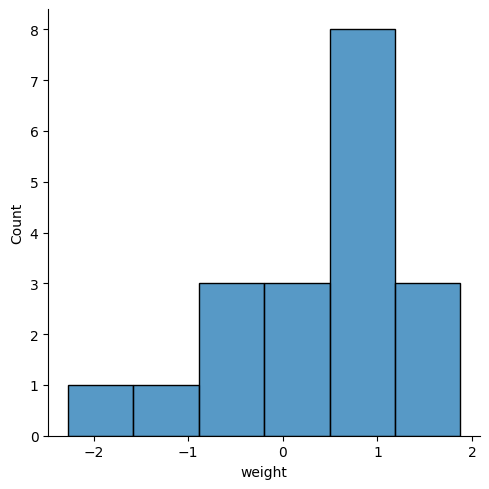

In [47]:
sns.displot(mdl_weights['weight'])

In [48]:
with open('models/LogReg.pkl', 'wb') as log_reg_path:
    pickle.dump(model, log_reg_path, protocol=4)

In [49]:
roc_auc = skm.roc_auc_score(y_true=y_train, y_score=model.predict_proba(X_train[features])[:, 1])
gini = 2 * roc_auc - 1

print(f'ROC-AUC: {roc_auc} / Gini: {gini}')

ROC-AUC: 0.8018100097181731 / Gini: 0.6036200194363461


##### Построим модель со взвешиванием наблюдений. В качестве алгоритма выберем Логистическую регрессию ElasticNet (для комбинирования L1 и L2 регуляризации)

In [50]:
model = sklm.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=np.linspace(0, 1, 12)
)

In [51]:
model.fit(
    X_train[features],
    y_train,
    sample_weight=X_train['weights']
)

LogisticRegressionCV(cv=5,
                     l1_ratios=array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091, 1.        ]),
                     penalty='elasticnet', random_state=56, solver='saga')

In [52]:
mdl_weights = pd.DataFrame({
    'feature': X_train[features].columns.to_list(),
    'weight': model.coef_.flatten().tolist(),
    'weight_abs': np.abs(model.coef_.flatten()).tolist()
}).sort_values('weight_abs', ascending=False)

mdl_weights

,feature,weight,weight_abs
13,checking_status,1.621343,1.621343
12,credit_history,1.356263,1.356263
9,job,-1.273817,1.273817
0,duration,1.090291,1.090291
8,savings_status,1.016389,1.016389
6,other_payment_plans,0.759516,0.759516
17,employment,0.658806,0.658806
18,purpose,0.646918,0.646918
10,housing,0.410802,0.410802
11,personal_status,0.391561,0.391561


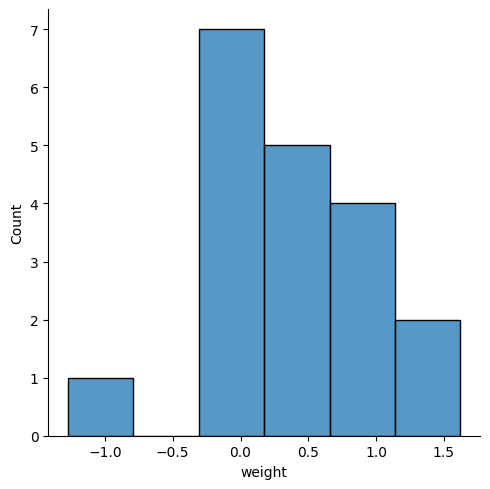

In [53]:
sns.displot(mdl_weights['weight'])

In [54]:
with open('models/LogRegSW.pkl', 'wb') as log_reg_path:
    pickle.dump(model, log_reg_path, protocol=4)

In [55]:
roc_auc = skm.roc_auc_score(y_true=y_train, y_score=model.predict_proba(X_train[features])[:, 1])
gini = 2 * roc_auc - 1

print(f'ROC-AUC: {roc_auc} / Gini: {gini}')

ROC-AUC: 0.7991526967930027 / Gini: 0.5983053935860054


## Оценим метрики качества на тенировочной выборке

В качестве основных показателей качества будем использовать 
- Gini ratio (для оценки ранжирования)
- F-beta Score (для подбора порога с заданным весом Precision для учёта дисбаланса классов)
- F1 Score (для анализа информативности метрики при условии дисбаланса классов)

In [56]:
model = pickle.load(open('models/LogReg.pkl', 'rb'))
model_sw = pickle.load(open('models/LogRegSW.pkl', 'rb'))

In [57]:
models_list = [model, model_sw]

In [58]:
def specificity(y_true, y_pred):
    return y_pred[(y_true == 0) & (y_pred == 0)].shape[0] / y_true[y_true == 0].shape[0]

def sensitivity(y_true, y_pred):
    return y_pred[(y_true == 1) & (y_pred == 1)].shape[0] / y_true[y_true == 1].shape[0] 

{'Without SW': 0.6969697, 'With SW': 0.47474747}


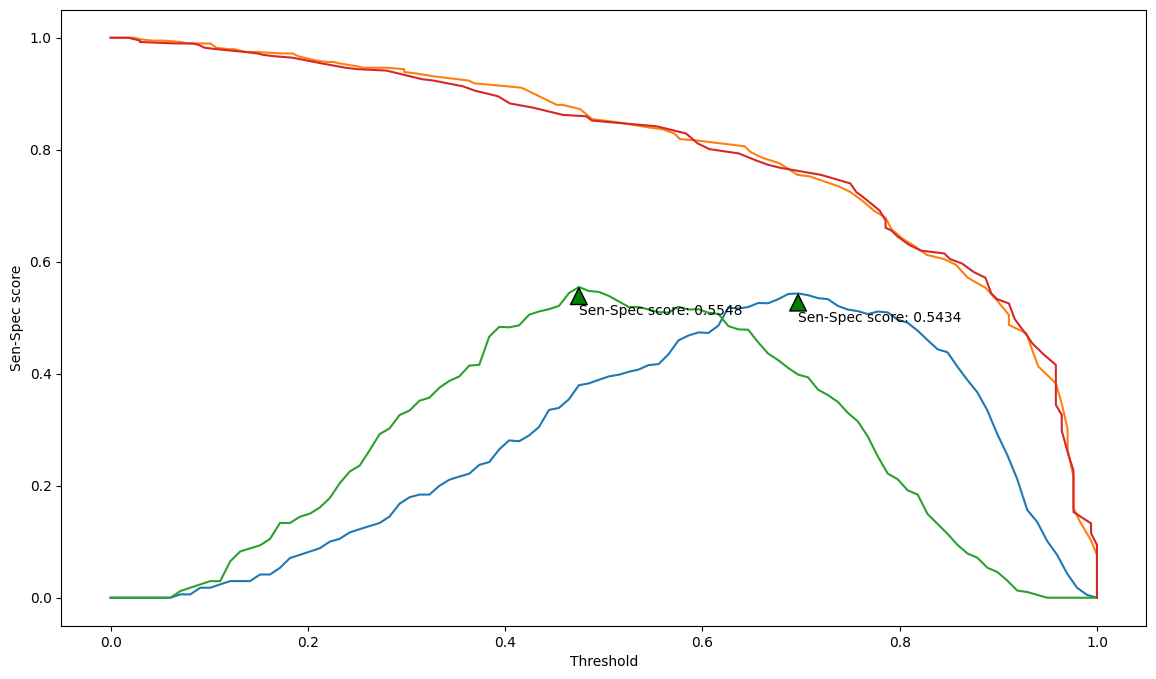

In [59]:
optimal_thresholds = {}

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(8)

for mdl, mdl_label in zip(models_list, ['Without SW', 'With SW']):
    df_mdl_scores_and_tresholds = pd.DataFrame()
    
    for threshold in np.linspace(0, 1, 100):
        df_mdl_scores_and_tresholds = pd.concat((
            df_mdl_scores_and_tresholds,
            pd.DataFrame({
                'threshold': [threshold], 
                'Specificity': specificity(y_train, np.where(mdl.predict_proba(X_train[features])[:, 1] >= threshold, 1, 0)),
                'Sensitivity': sensitivity(y_train, np.where(mdl.predict_proba(X_train[features])[:, 1] >= threshold, 1, 0)),
                'Sen-Spec': [specificity(y_train, np.where(mdl.predict_proba(X_train[features])[:, 1] >= threshold, 1, 0)) * sensitivity(y_train, np.where(mdl.predict_proba(X_train[features])[:, 1] >= threshold, 1, 0))]
            })
        )).reset_index(drop=True)

    max_f1_score = df_mdl_scores_and_tresholds[df_mdl_scores_and_tresholds['Sen-Spec'] == df_mdl_scores_and_tresholds['Sen-Spec'].max()]

    optimal_thresholds[mdl_label] = float(np.round(max_f1_score['threshold'].values[0], decimals=8))
                
    ax.plot(df_mdl_scores_and_tresholds['threshold'], df_mdl_scores_and_tresholds['Sen-Spec'])
    ax.plot(df_mdl_scores_and_tresholds['Specificity'], df_mdl_scores_and_tresholds['Sensitivity'])
    
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Sen-Spec score')
    
    ax.annotate(
        f"Sen-Spec score: {np.round(max_f1_score['Sen-Spec'].values[0], decimals=4)}", 
        xy=(max_f1_score['threshold'].values[0], max_f1_score['Sen-Spec'].values[0]), 
        xytext=(max_f1_score['threshold'].values[0], max_f1_score['Sen-Spec'].values[0] - 0.05), 
        arrowprops=dict(facecolor='green', shrink=0.05)
    )
    # ax.set_title(f'Model {mdl_label}')

print(optimal_thresholds)
    
plt.show()

In [60]:
with open('models/config/LogReg/ss_thresholds.pkl', 'wb') as th_path:
    pickle.dump(optimal_thresholds, th_path, protocol=4)

0.6546536707079771
{'Without SW': 0.62626263, 'With SW': 0.47474747}


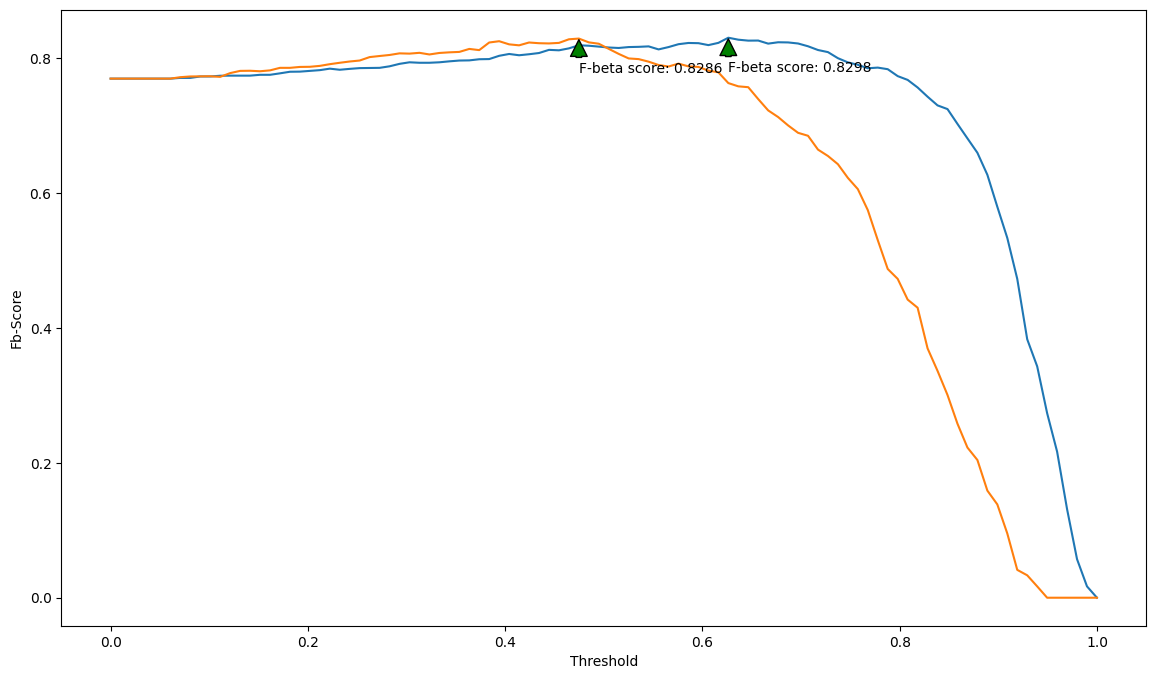

In [61]:
optimal_thresholds = {}
optimal_beta = (1 / ((y_train[y_train == 1].shape[0] / y_train.shape[0]) / (y_train[y_train == 0].shape[0] / y_train.shape[0]))) ** 0.5

print(optimal_beta)

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(8)

for mdl, mdl_label in zip(models_list, ['Without SW', 'With SW']):
    df_mdl_scores_and_tresholds = pd.DataFrame()
    
    for treshold in np.linspace(0, 1, 100):
        df_mdl_scores_and_tresholds = pd.concat((
            df_mdl_scores_and_tresholds,
            pd.DataFrame({'threshold': [treshold], 'fb-Score': [skm.fbeta_score(y_train, np.where(mdl.predict_proba(X_train[features])[:, 1] >= treshold, 1, 0), beta=optimal_beta)]})
        )).reset_index(drop=True)

    max_f1_score = df_mdl_scores_and_tresholds[df_mdl_scores_and_tresholds['fb-Score'] == df_mdl_scores_and_tresholds['fb-Score'].max()]

    optimal_thresholds[mdl_label] = float(np.round(max_f1_score['threshold'].values[0], decimals=8))
                
    ax.plot(df_mdl_scores_and_tresholds['threshold'], df_mdl_scores_and_tresholds['fb-Score'])
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Fb-Score')
    
    ax.annotate(
        f"F-beta score: {np.round(max_f1_score['fb-Score'].values[0], decimals=4)}", 
        xy=(max_f1_score['threshold'].values[0], max_f1_score['fb-Score'].values[0]), 
        xytext=(max_f1_score['threshold'].values[0], max_f1_score['fb-Score'].values[0] - 0.05), 
        arrowprops=dict(facecolor='green', shrink=0.05)
    )
    # ax.set_title(f'Model {mdl_label}')

print(optimal_thresholds)
    
plt.show()

In [62]:
with open('models/config/LogReg/fb_thresholds.pkl', 'wb') as th_path:
    pickle.dump(optimal_thresholds, th_path, protocol=4)

0.6546536707079771
{'Without SW': 0.47474747, 'With SW': 0.26262626}


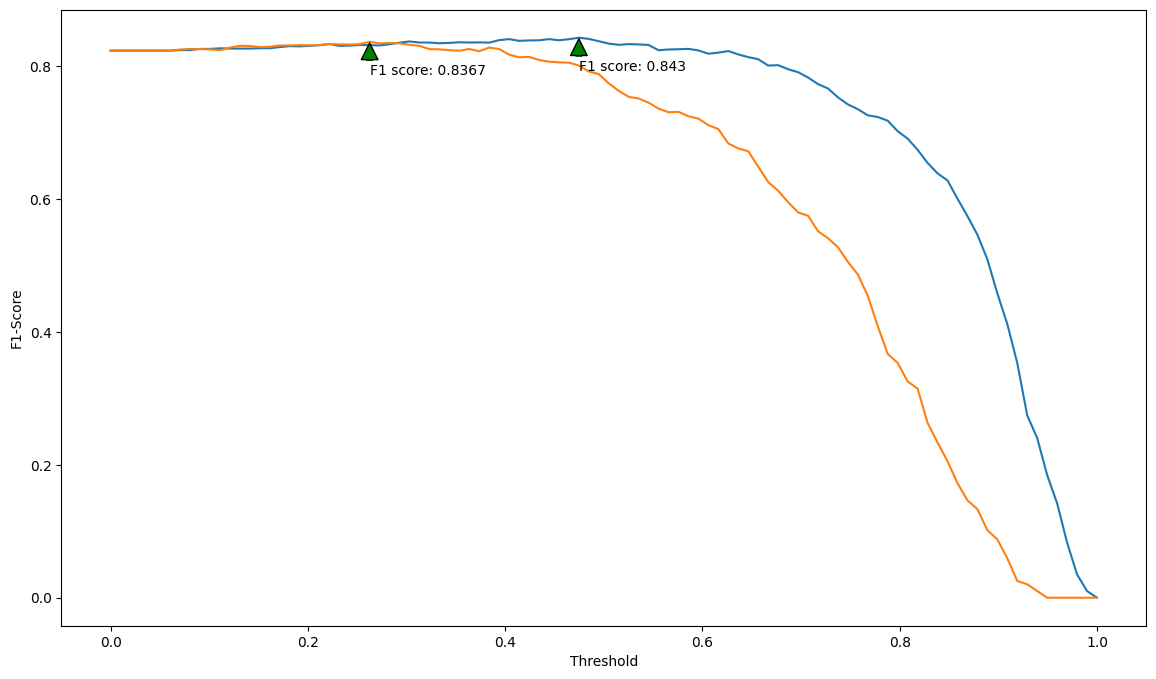

In [63]:
optimal_thresholds = {}
optimal_beta = (1 / ((y_train[y_train == 1].shape[0] / y_train.shape[0]) / (y_train[y_train == 0].shape[0] / y_train.shape[0]))) ** 0.5

print(optimal_beta)

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(8)

for mdl, mdl_label in zip(models_list, ['Without SW', 'With SW']):
    df_mdl_scores_and_tresholds = pd.DataFrame()
    
    for treshold in np.linspace(0, 1, 100):
        df_mdl_scores_and_tresholds = pd.concat((
            df_mdl_scores_and_tresholds,
            pd.DataFrame({'threshold': [treshold], 'fb-Score': [skm.f1_score(y_train, np.where(mdl.predict_proba(X_train[features])[:, 1] >= treshold, 1, 0))]})
        )).reset_index(drop=True)

    max_f1_score = df_mdl_scores_and_tresholds[df_mdl_scores_and_tresholds['fb-Score'] == df_mdl_scores_and_tresholds['fb-Score'].max()]

    optimal_thresholds[mdl_label] = float(np.round(max_f1_score['threshold'].values[0], decimals=8))
                
    ax.plot(df_mdl_scores_and_tresholds['threshold'], df_mdl_scores_and_tresholds['fb-Score'])
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1-Score')
    
    ax.annotate(
        f"F1 score: {np.round(max_f1_score['fb-Score'].values[0], decimals=4)}", 
        xy=(max_f1_score['threshold'].values[0], max_f1_score['fb-Score'].values[0]), 
        xytext=(max_f1_score['threshold'].values[0], max_f1_score['fb-Score'].values[0] - 0.05), 
        arrowprops=dict(facecolor='green', shrink=0.05)
    )
    # ax.set_title(f'Model {mdl_label}')

print(optimal_thresholds)
    
plt.show()

In [64]:
with open('models/config/LogReg/f1_thresholds.pkl', 'wb') as th_path:
    pickle.dump(optimal_thresholds, th_path, protocol=4)

In [65]:
optimal_thresholds = pickle.load(open('models/config/LogReg/ss_thresholds.pkl', 'rb'))

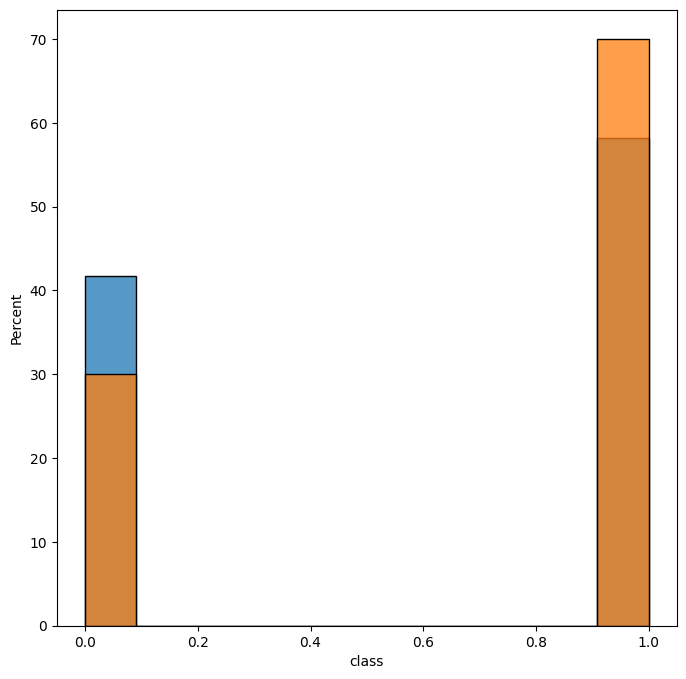

In [66]:
# Without sample weights

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(8)
        
sns.histplot(data=np.where(model.predict_proba(X_train[features])[:, 1] >= optimal_thresholds['Without SW'], 1, 0), stat='percent', ax=ax)
sns.histplot(data=y_train, stat='percent', ax=ax)

plt.show()

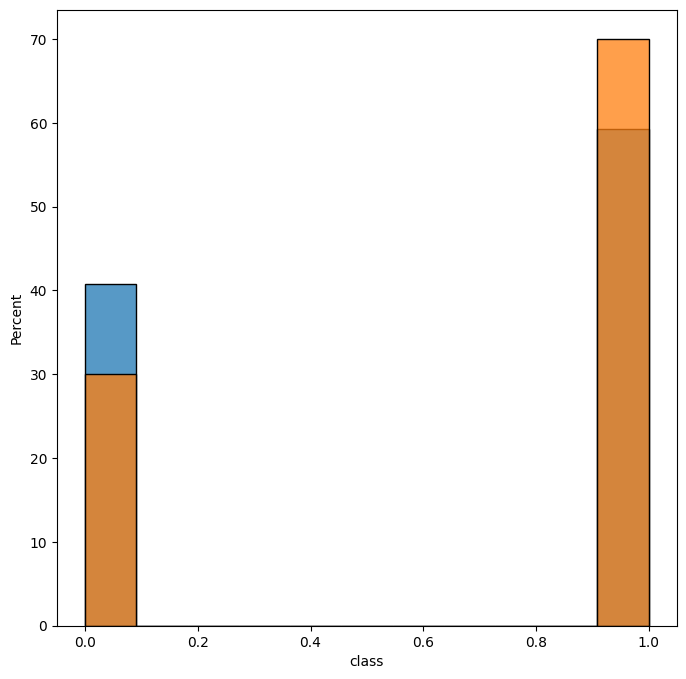

In [67]:
# With sample weights

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(8)
        
sns.histplot(data=np.where(model_sw.predict_proba(X_train[features])[:, 1] >= optimal_thresholds['With SW'], 1, 0), stat='percent', ax=ax)
sns.histplot(data=y_train, stat='percent', ax=ax)

plt.show()

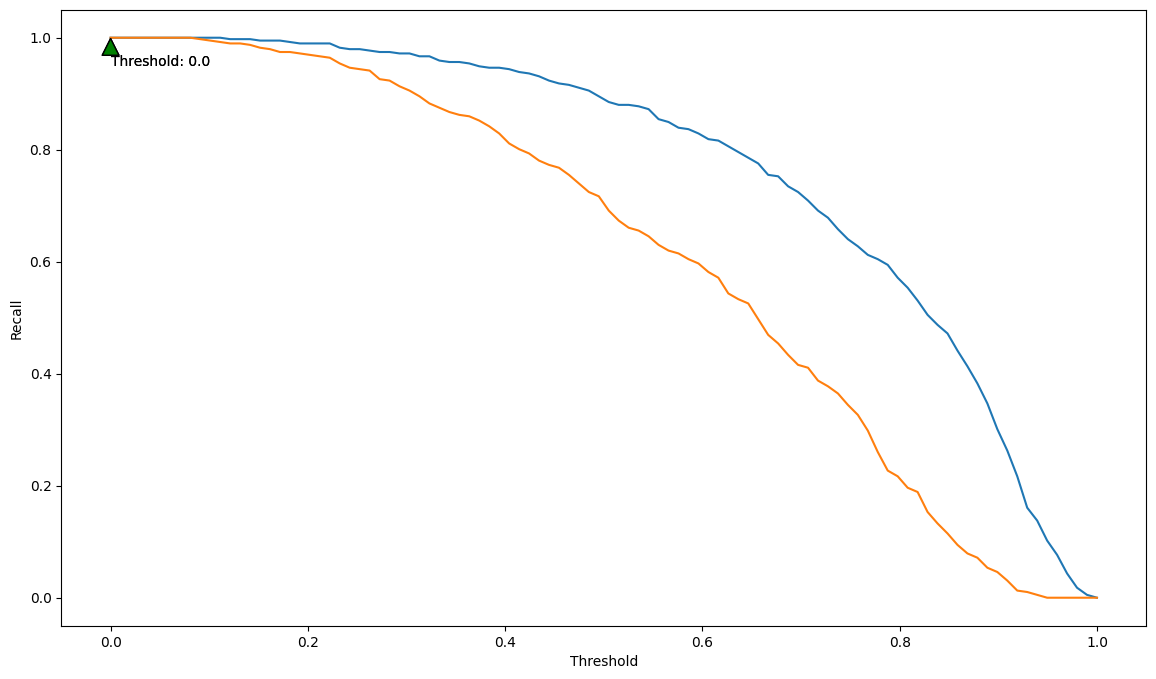

In [68]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(8)

for mdl, mdl_label in zip(models_list, ['Without SW', 'With SW']):
    df_mdl_scores_and_tresholds = pd.DataFrame()
    
    for treshold in np.linspace(0, 1, 100):
        df_mdl_scores_and_tresholds = pd.concat((
            df_mdl_scores_and_tresholds,
            pd.DataFrame({'threshold': [treshold], 'Recall': [skm.recall_score(y_train, np.where(mdl.predict_proba(X_train[features])[:, 1] >= treshold, 1, 0))]})
        )).reset_index(drop=True)

    max_f1_score = df_mdl_scores_and_tresholds[df_mdl_scores_and_tresholds['Recall'] == df_mdl_scores_and_tresholds['Recall'].max()]
                
    ax.plot(df_mdl_scores_and_tresholds['threshold'], df_mdl_scores_and_tresholds['Recall'])
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Recall')
    
    ax.annotate(
        f"Threshold: {np.round(max_f1_score['threshold'].values[0], decimals=4)}", 
        xy=(max_f1_score['threshold'].values[0], max_f1_score['Recall'].values[0]), 
        xytext=(max_f1_score['threshold'].values[0], max_f1_score['Recall'].values[0] - 0.05), 
        arrowprops=dict(facecolor='green', shrink=0.05)
    )
    # ax.set_title(f'Model {mdl_label}')
        
plt.show()

0.9596
0.8586


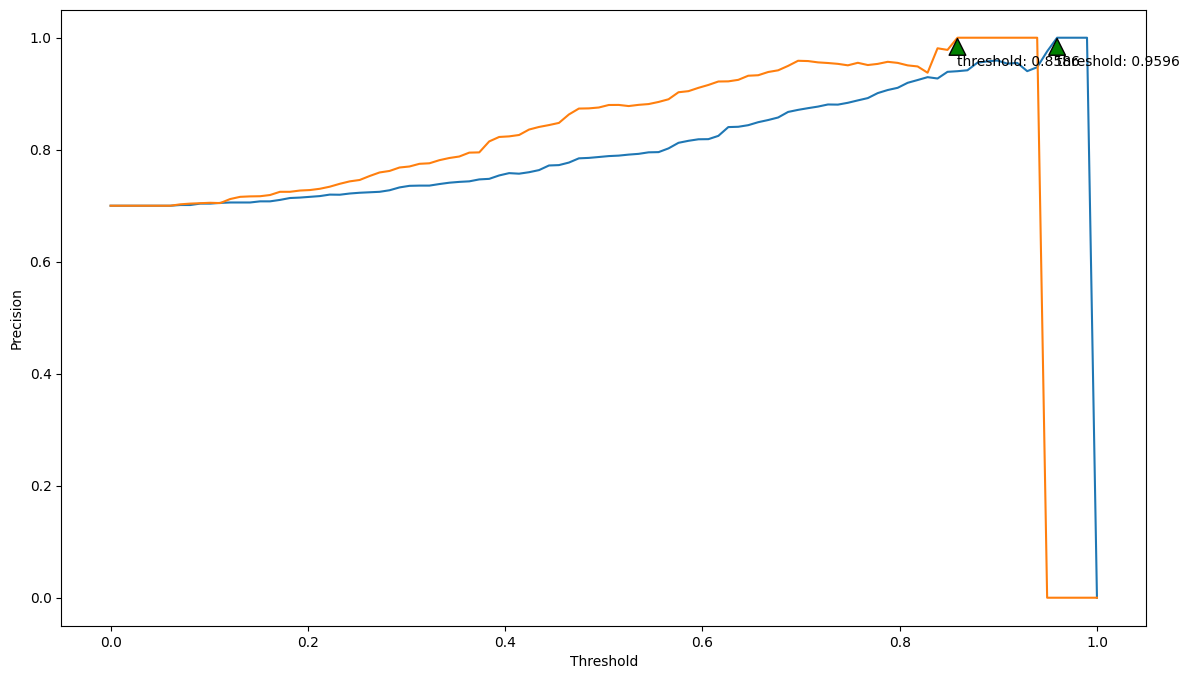

In [69]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(8)

for mdl, mdl_label in zip(models_list, ['Without SW', 'With SW']):
    df_mdl_scores_and_tresholds = pd.DataFrame()
    
    for treshold in np.linspace(0, 1, 100):
        df_mdl_scores_and_tresholds = pd.concat((
            df_mdl_scores_and_tresholds,
            pd.DataFrame({'threshold': [treshold], 'Precision': [skm.precision_score(y_train, np.where(mdl.predict_proba(X_train[features])[:, 1] >= treshold, 1, 0))]})
        )).reset_index(drop=True)

    max_f1_score = df_mdl_scores_and_tresholds[df_mdl_scores_and_tresholds['Precision'] == df_mdl_scores_and_tresholds['Precision'].max()]
    print(np.round(max_f1_score['threshold'].values[0], decimals=4))
                
    ax.plot(df_mdl_scores_and_tresholds['threshold'], df_mdl_scores_and_tresholds['Precision'])
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Precision')
    
    ax.annotate(
        f"threshold: {np.round(max_f1_score['threshold'].values[0], decimals=4)}", 
        xy=(max_f1_score['threshold'].values[0], max_f1_score['Precision'].values[0]), 
        xytext=(max_f1_score['threshold'].values[0], max_f1_score['Precision'].values[0] - 0.05), 
        arrowprops=dict(facecolor='green', shrink=0.05)
    )
    # ax.set_title(f'Model {mdl_label}')
        
plt.show()

#### Оценка метрик на тестовом семпле

In [70]:
cat_target_encoder = pickle.load(open('models/config/LogReg/CatTargetEncoder.pkl', 'rb'))
num_target_encoder = pickle.load(open('models/config/LogReg/NumTargetEncoder.pkl', 'rb'))
num_features_discretizer = pickle.load(open('models/config/LogReg/NumFeaturesDiscretizer.pkl', 'rb'))
scaler = pickle.load(open('models/config/LogReg/Scaler.pkl', 'rb'))

In [71]:
model = pickle.load(open('models/LogReg.pkl', 'rb'))
model_sw = pickle.load(open('models/LogRegSW.pkl', 'rb'))

In [72]:
X_test.loc[:, cat_features] = cat_target_encoder.transform(X_test.loc[:, cat_features].to_numpy())
X_test.loc[:, num_features] = num_features_discretizer.transform(X_test.loc[:, num_features])
X_test.loc[:, num_features] = num_target_encoder.transform(X_test.loc[:, num_features].to_numpy())
X_test.loc[:, features] = scaler.transform(X_test.loc[:, features]) - 0.5

In [73]:
pathes = {
    'Sen-Spec thresholds': 'models/config/LogReg/ss_thresholds.pkl',
    'F-beta thresholds': 'models/config/LogReg/fb_thresholds.pkl',
    'F1 thresholds': 'models/config/LogReg/f1_thresholds.pkl'
}

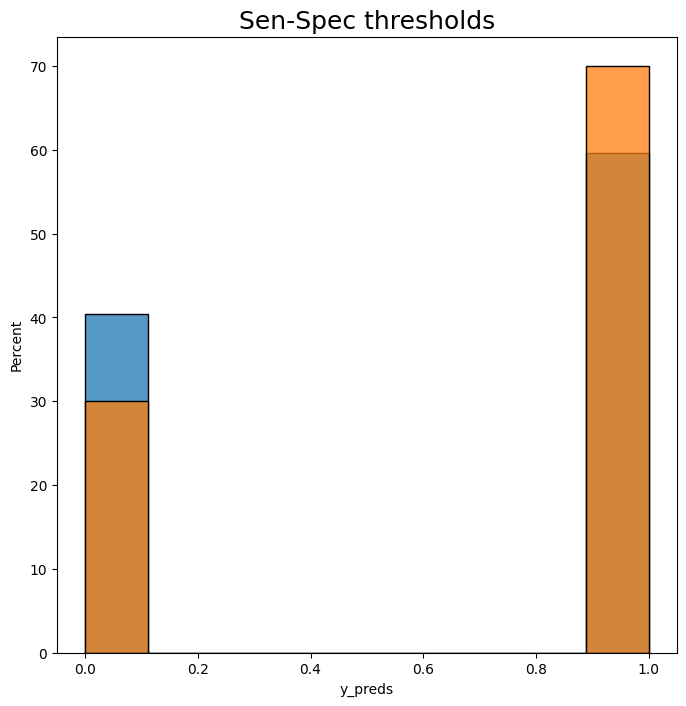


        Model:ROC-AUC: 0.7595072751322751
        Gini: 0.5190145502645502
        F1 Score: 0.7652733118971061
        F-beta Score: 0.7906976744186045
        Precision: 0.8321678321678322
        Recall: 0.7083333333333334
    
	Доля не выявленных дефолтов, %: 33.333333333333336
	Доля не выявленных не дефолтов, %: 29.166666666666664
	Максимальные потери подвыборки портфеля в условных единицах: 71385.0
	Максимальные потери подвыборки портфеля в %: 9.750717115148204


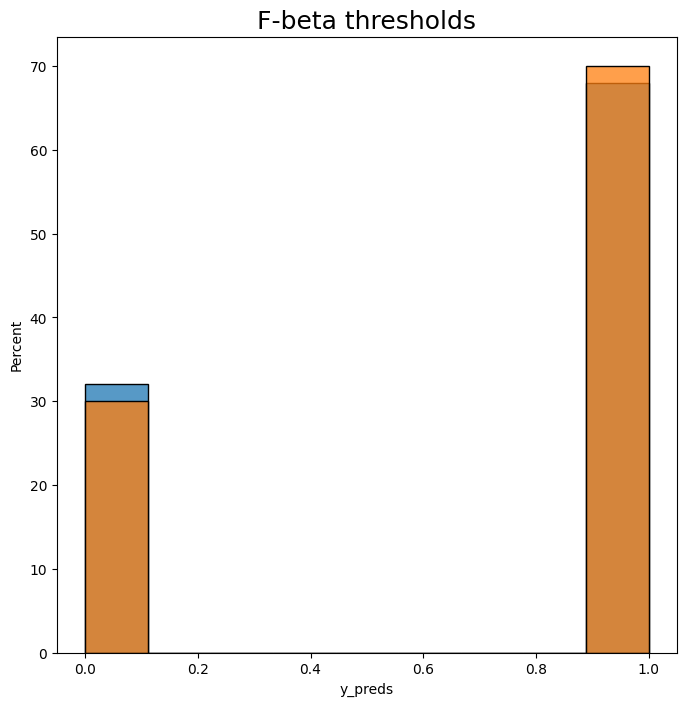


        Model:ROC-AUC: 0.7595072751322751
        Gini: 0.5190145502645502
        F1 Score: 0.8096676737160121
        F-beta Score: 0.8145896656534954
        Precision: 0.8220858895705522
        Recall: 0.7976190476190477
    
	Доля не выявленных дефолтов, %: 40.27777777777778
	Доля не выявленных не дефолтов, %: 20.238095238095234
	Максимальные потери подвыборки портфеля в условных единицах: 89552.0
	Максимальные потери подвыборки портфеля в %: 12.232208714656467


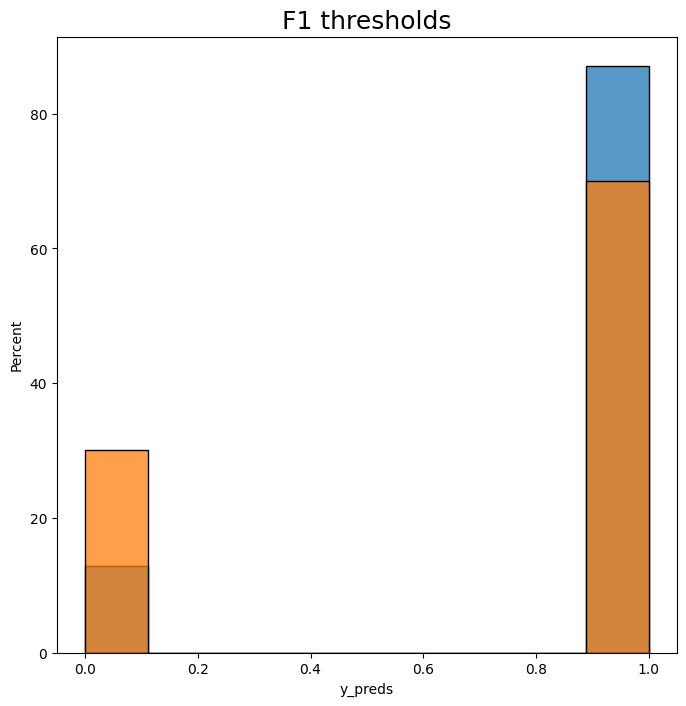


        Model:ROC-AUC: 0.7595072751322751
        Gini: 0.5190145502645502
        F1 Score: 0.8328912466843501
        F-beta Score: 0.7981698017285205
        Precision: 0.7511961722488039
        Recall: 0.9345238095238095
    
	Доля не выявленных дефолтов, %: 72.22222222222221
	Доля не выявленных не дефолтов, %: 6.547619047619047
	Максимальные потери подвыборки портфеля в условных единицах: 166504.0
	Максимальные потери подвыборки портфеля в %: 22.74334107362382


In [74]:
model = model

for path_name, path in pathes.items():
    optimal_thresholds = pickle.load(open(path, 'rb'))
    
    X_test.loc[:, 'y_preds'] = np.where(model.predict_proba(X_test[features])[:, 1] >= optimal_thresholds['Without SW'], 1, 0)

    THRESHOLD = optimal_thresholds['Without SW']
    
    roc_auc = skm.roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test[features])[:, 1])
    gini = 2 * roc_auc - 1
    f1_score = skm.f1_score(y_test, np.where(model.predict_proba(X_test[features])[:, 1] >= THRESHOLD, 1, 0))
    fbeta_score = skm.fbeta_score(y_test, np.where(model.predict_proba(X_test[features])[:, 1] >= THRESHOLD, 1, 0), beta=optimal_beta)
    precision_score = skm.precision_score(y_test, np.where(model.predict_proba(X_test[features])[:, 1] >= THRESHOLD, 1, 0))
    recall_score = skm.recall_score(y_test, np.where(model.predict_proba(X_test[features])[:, 1] >= THRESHOLD, 1, 0))
    
    # Without sample weights
    
    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(8)
            
    sns.histplot(data=X_test.loc[:, 'y_preds'], stat='percent', ax=ax)
    sns.histplot(data=y_test, stat='percent', ax=ax)

    plt.title(path_name, fontsize=18)
    
    plt.show()
    
    print(f'''
        Model:ROC-AUC: {roc_auc}
        Gini: {gini}
        F1 Score: {f1_score}
        F-beta Score: {fbeta_score}
        Precision: {precision_score}
        Recall: {recall_score}
    ''')

    print(f"\tДоля не выявленных дефолтов, %: {(1 - (X_test[(y_test == 0) & (X_test['y_preds'] == 0)].shape[0] / y_test[y_test == 0].shape[0])) * 100}")
    print(f"\tДоля не выявленных не дефолтов, %: {(1 - (X_test[(y_test == 1) & (X_test['y_preds'] == 1)].shape[0] / y_test[y_test == 1].shape[0])) * 100}")
    print(f"\tМаксимальные потери подвыборки портфеля в условных единицах: {float(X_test_orig.loc[np.where((y_test == 0) & (X_test.loc[:, 'y_preds'] == 1), True, False), 'credit_amount'].sum())}")
    print(f"\tМаксимальные потери подвыборки портфеля в %: {(float(X_test_orig.loc[np.where((y_test == 0) & (X_test.loc[:, 'y_preds'] == 1), True, False), 'credit_amount'].sum()) / X_test_orig.loc[:, 'credit_amount'].sum()) * 100}")

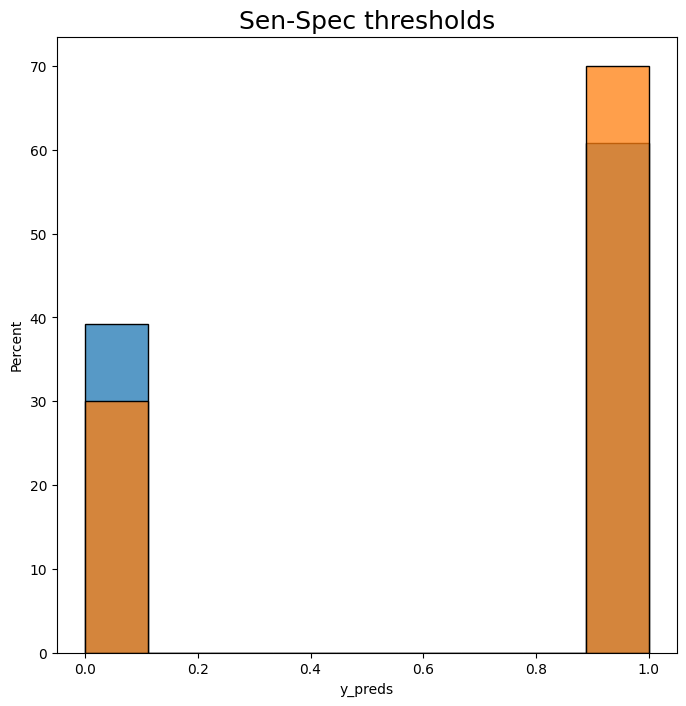


        Model:ROC-AUC: 0.7548776455026455
        Gini: 0.5097552910052909
        F1 Score: 0.7707006369426752
        F-beta Score: 0.7929226736566185
        Precision: 0.8287671232876712
        Recall: 0.7202380952380952
    
	Доля не выявленных дефолтов, %: 34.72222222222222
	Доля не выявленных не дефолтов, %: 27.976190476190478
	Максимальные потери подвыборки портфеля в условных единицах: 73307.0
	Максимальные потери подвыборки портфеля в %: 10.013249556071575


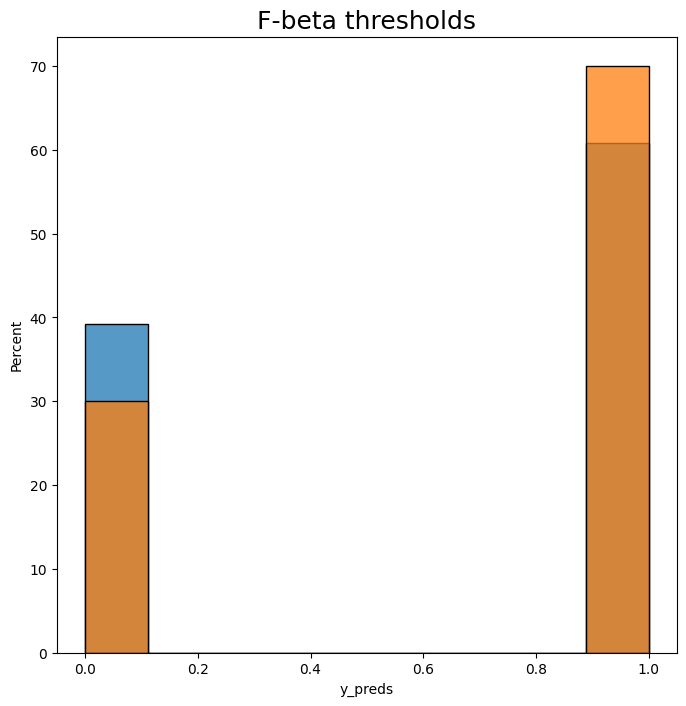


        Model:ROC-AUC: 0.7548776455026455
        Gini: 0.5097552910052909
        F1 Score: 0.7707006369426752
        F-beta Score: 0.7929226736566185
        Precision: 0.8287671232876712
        Recall: 0.7202380952380952
    
	Доля не выявленных дефолтов, %: 34.72222222222222
	Доля не выявленных не дефолтов, %: 27.976190476190478
	Максимальные потери подвыборки портфеля в условных единицах: 73307.0
	Максимальные потери подвыборки портфеля в %: 10.013249556071575


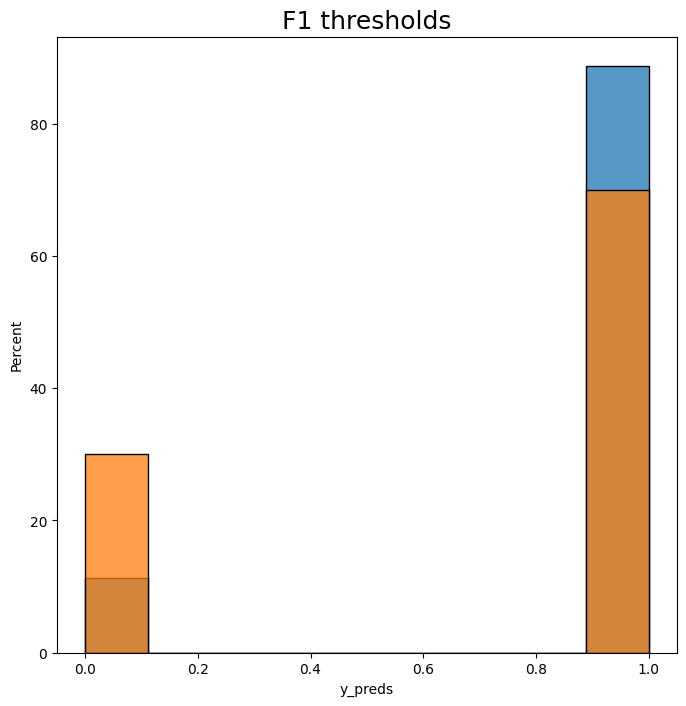


        Model:ROC-AUC: 0.7548776455026455
        Gini: 0.5097552910052909
        F1 Score: 0.8241469816272966
        F-beta Score: 0.7869674185463658
        Precision: 0.7370892018779343
        Recall: 0.9345238095238095
    
	Доля не выявленных дефолтов, %: 77.77777777777779
	Доля не выявленных не дефолтов, %: 6.547619047619047
	Максимальные потери подвыборки портфеля в условных единицах: 185546.0
	Максимальные потери подвыборки портфеля в %: 25.344351864499387


In [75]:
model = model_sw

for path_name, path in pathes.items():
    optimal_thresholds = pickle.load(open(path, 'rb'))
    
    X_test.loc[:, 'y_preds'] = np.where(model.predict_proba(X_test[features])[:, 1] >= optimal_thresholds['With SW'], 1, 0)

    THRESHOLD = optimal_thresholds['With SW']
    
    roc_auc = skm.roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test[features])[:, 1])
    gini = 2 * roc_auc - 1
    f1_score = skm.f1_score(y_test, np.where(model.predict_proba(X_test[features])[:, 1] >= THRESHOLD, 1, 0))
    fbeta_score = skm.fbeta_score(y_test, np.where(model.predict_proba(X_test[features])[:, 1] >= THRESHOLD, 1, 0), beta=optimal_beta)
    precision_score = skm.precision_score(y_test, np.where(model.predict_proba(X_test[features])[:, 1] >= THRESHOLD, 1, 0))
    recall_score = skm.recall_score(y_test, np.where(model.predict_proba(X_test[features])[:, 1] >= THRESHOLD, 1, 0))
    
    # With sample weights
    
    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(8)
            
    sns.histplot(data=X_test.loc[:, 'y_preds'], stat='percent', ax=ax)
    sns.histplot(data=y_test, stat='percent', ax=ax)

    plt.title(path_name, fontsize=18)
    
    plt.show()
    
    print(f'''
        Model:ROC-AUC: {roc_auc}
        Gini: {gini}
        F1 Score: {f1_score}
        F-beta Score: {fbeta_score}
        Precision: {precision_score}
        Recall: {recall_score}
    ''')

    print(f"\tДоля не выявленных дефолтов, %: {(1 - (X_test[(y_test == 0) & (X_test['y_preds'] == 0)].shape[0] / y_test[y_test == 0].shape[0])) * 100}")
    print(f"\tДоля не выявленных не дефолтов, %: {(1 - (X_test[(y_test == 1) & (X_test['y_preds'] == 1)].shape[0] / y_test[y_test == 1].shape[0])) * 100}")
    print(f"\tМаксимальные потери подвыборки портфеля в условных единицах: {float(X_test_orig.loc[np.where((y_test == 0) & (X_test.loc[:, 'y_preds'] == 1), True, False), 'credit_amount'].sum())}")
    print(f"\tМаксимальные потери подвыборки портфеля в %: {(float(X_test_orig.loc[np.where((y_test == 0) & (X_test.loc[:, 'y_preds'] == 1), True, False), 'credit_amount'].sum()) / X_test_orig.loc[:, 'credit_amount'].sum()) * 100}")

# Вывод из исследования и выбор модели

В качестве лучшей модели выбираем модель полученную без взвешивания наблюдений и порогом выбранным по Специфичности-Чувствительности. 
На тестовой выборке:
 - Критерий Gini составляет 0.519 (модель лучше случайного прогноза на 51,9%. В сравнении со случайной либо констанстной моделью, текущая модель правильно сопоставляет 75.9% пар)
 - Модель выявляет две трети дефолтов
 - Доля ложно выявленных дефолтов составляет менее 30% (консервативно считаем, что Credit Limit = EAD за не имением детальных данных об утилизации кридитного Лимита)
 - Максимальные потери порфтеля от пропущенных дефолтов составляют менее 10% (консервативно считаем, что Credit Limit = EAD за не имением детальных данных об утилизации кридитного Лимита)

Выбор в пользу более консервативных вариантов может быть не целесообразен, так как недополученная прибыль (проценты, коммиссии и прочее) от потери клиентов в следствие их ложного отнесения к дефолтным может перекрывать негативный экономический эффект от истинных дефолтов

- Итоговая модель: 'models/LogReg.pkl'
- Итоговый порог: 'models/config/LogReg/ss_thresholds.pkl'

# Какие фичи можно было бы дособрать

- Среднемесячный остаток на расчётных и накопительных счетах и вкладах
- Регулярная норма (в процентах и деньгах) накоплений заёмщика (чистое сальдо расчётного счета за месяц / дебит расчётного счета за месяц) (в данной фиче считаем накопления сформированные только за счёт дохода в каждом месяце)
- Регулярная норма (в процентах и деньгах) накоплений домохозяйства, членом которого явялется заёмщик
- Наличие постоянной регистрации займщика в административном районе расположения филиала Банка
- Способ пребывания заёмщика в административном районе расположения филиала Банка (аренда жилья, жилье в собственности)
- Рыночная стоимость личного имущества заёмщика (имущества собственность заёмщика над которым подтверждена)
- Кредитная нагрузка (отношение чистого денежного потока заёмщика в месяц к объёму регулярного платежа по предполагаемому кредитному требованию)
- История банкротств займщика
- Средневзвешанный уровень утилизации текущих кредитных требований
- Участие заёмщика в качестве приглашенного свидетеля/фигуранта арбитражных и уголовных дел
- И т.д.